In [1]:
import os
import json
import random
random.seed(0)
import math
from copy import deepcopy
import argparse
from tqdm import tqdm

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from generator import Generator, G_args
from discriminator import Discriminator, D_args
from rollout import Rollout
from utils import MyDataset
from torch.utils.data import DataLoader

# parser = argparse.ArgumentParser(description='Training Parameter')
# parser.add_argument('--cuda', action='store', type=int, default=0)
# parser.add_argument('--batch_size', help="batch size during training", type=int, default=64)

# args = parser.parse_args()
# print(args)

with open("../local/word_map.json", "r") as json_file:
    word_map = json.load(json_file)
with open("../local/dataset_batch.json", "r") as json_file:
    dataset = json.load(json_file)
index_map = {}
for key in word_map.keys():
    index_map[word_map[key]] = key

input_data = []
label_data = []
for category in dataset.keys():
    if category == "max_seq_len":
        continue
    input_data += deepcopy(dataset[category])
    label_data += [int(category)] * len(dataset[category])
rd_index = np.arange(len(input_data))
random.shuffle(rd_index)
input_data = [input_data[i] for i in rd_index]
label_data = [label_data[i] for i in rd_index]
total_size = len(input_data)
train_size = int(total_size * 0.8)

In [2]:
# Basic Training Paramters
SEED = 0
BATCH_SIZE = 64
VOCAB_SIZE = word_map["*"] + 1
MAX_SEQ_LEN = dataset["max_seq_len"]
USE_CUDA = False

# Genrator Parameters
g_args = G_args(vocab_size=VOCAB_SIZE, 
                emb_dim=64, 
                hidden_dim=64)
# Discriminator Parameters
d_args = D_args(num_classes=2, 
                vocab_size=VOCAB_SIZE, 
                emb_dim=64, 
                filter_sizes=[3, 4, 5], 
                num_filters=[100, 100, 100], 
                dropout=0.5)
# Adversarial Parameters
a_args = D_args(num_classes=3, 
                vocab_size=VOCAB_SIZE, 
                emb_dim=64, 
                filter_sizes=[3,4,5], 
                num_filters=[100, 100, 100], 
                dropout=0.5)
# Dataset Parameters
train_dataset = MyDataset(input_data=input_data[:train_size],
                          label_data=label_data[:train_size],
                          word_map=word_map,
                          max_len=MAX_SEQ_LEN)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
test_dataset = MyDataset(input_data=input_data[train_size:],
                         label_data=label_data[train_size:],
                         word_map=word_map,
                         max_len=MAX_SEQ_LEN)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

In [3]:
random.seed(SEED)
np.random.seed(SEED)

# Define Networks
generator = Generator(g_args, USE_CUDA)
discriminator = Discriminator(d_args)
if USE_CUDA:
    generator = generator.cuda()
    discriminator = discriminator.cuda()

In [5]:
def pretrain_epoch(model, dataloader, criterion, optimizer, model_path, use_cuda=False):
    total_loss = 0.
    total_words = 0.
    for batch in tqdm(dataloader):
        data = batch["x"]
        target = batch["x"][:,:,0]
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        target = target.contiguous().view(-1)
        pred = model.forward(data)
        loss = criterion(pred, target)
        total_loss += loss.item()
        total_words += data.size(0) * data.size(1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    target_ = target.detach().cpu().numpy()
    _, pred_ = torch.max(pred, axis=-1)
    pred_ = pred_.cpu().numpy()
    target_query = []
    pred_query = []
    for i in range(72):
        target_query.append(index_map[target_[i]])
        pred_query.append(index_map[pred_[i]])
    print("[INFO] Target query: ", target_query)
    print("[INFO] Predicted query: ", pred_query)
    torch.save(model.state_dict(), model_path)
    return math.exp(total_loss / total_words)

def pretest_epoch(model, dataloader, criterion, optimizer, model_path, use_cuda=False):
    total_loss = 0.
    total_words = 0.
    for batch in tqdm(dataloader):
        data = batch["x"]
        target = batch["x"][:,:,0]
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        target = target.contiguous().view(-1)
        with torch.no_grad():
            pred = model.forward(data)
            loss = criterion(pred, target)
            total_loss += loss.item()
            total_words += data.size(0) * data.size(1)
    target_ = target.detach().cpu().numpy()
    _, pred_ = torch.max(pred, axis=-1)
    pred_ = pred_.cpu().numpy()
    target_query = []
    pred_query = []
    for i in range(72):
        target_query.append(index_map[target_[i]])
        pred_query.append(index_map[pred_[i]])
    print("[INFO] Target query: ", target_query)
    print("[INFO] Predicted query: ", pred_query)
    torch.save(model.state_dict(), model_path)
    return math.exp(total_loss / total_words)

In [6]:
# Pretrain Generator using MLE
PRE_EPOCH_NUM = 100
gen_criterion = nn.NLLLoss(reduction='sum')
gen_optimizer = optim.Adam(generator.parameters(), lr=0.01)
G_path = "../param/generator.pkl"
if USE_CUDA:
    gen_criterion = gen_criterion.cuda()
print('[INFO] Pretrain with MLE ...')
train_loss_list = []
test_loss_list = []
for epoch in range(PRE_EPOCH_NUM):
    print('[INFO] Start epoch [%d] ...'% (epoch))
    train_loss = pretrain_epoch(generator, train_loader, gen_criterion, gen_optimizer, G_path, USE_CUDA)
    test_loss = pretest_epoch(generator, test_loader, gen_criterion, gen_optimizer, G_path, USE_CUDA)
    print('[INFO] End epoch [%d], train Loss: %.4f, test loss: %.4f'% (epoch, train_loss, test_loss))
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)



  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Pretrain with MLE ...
[INFO] Start epoch [0] ...


 10%|█         | 1/10 [00:00<00:01,  7.25it/s]

[INFO] Target query:  ['<SOS>', 'spear', 'pregnant', 'again', '<POS>', 'spear', 'pregnant', '<POS>', 'pregnant', '<POS>', 'spear', 'pregnant', '<POS>', 'spear', 'pregnant', 'photo', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'wallpaper', '<POS>', 'dell', '<POS>', 'what', 'be', 'the', 'best', 'computer', 'processor', '<POS>', 'drive', 'wo', 'auto', 'load', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [0], train Loss: 0.6039, test loss: 0.4755
[INFO] Start epoch [1] ...


 10%|█         | 1/10 [00:00<00:01,  7.25it/s]

[INFO] Target query:  ['<SOS>', 'information', 'on', 'how', 'to', 'get', 'rid', 'of', 'a', '<POS>', 'pattern', 'for', 'plastic', 'canvas', '<POS>', 'making', 'a', 'cover', 'for', 'a', 'resume', '<POS>', 'making', 'a', 'cover', 'letter', 'for', 'a', 'resume', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'baby', 'shower', 'idea', '<POS>', 'baby', 'shower', 'favor', '<POS>', 'creative', 'baby', 'shower', '<POS>', 'creative', 'baby', 'shower', 'favor', '<POS>', 'creative', 'baby', 'shower', 'favor', '<POS>', 'homemade', 'baby', 'shower', 'favor', '<POS>', 'picture', 'of', 'baby', 'shower', 'favor', '<POS>', 'homemade', 'baby', 'shower', 'favor', '<POS>', 'picture', 'of', 'baby', 'shower', 'favor', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '*'

 10%|█         | 1/10 [00:00<00:01,  7.25it/s]

[INFO] Target query:  ['<SOS>', 'black', 'and', 'baby', 'blue', 'air', 'force', 'one', '<POS>', 'baby', 'blue', 'air', 'force', 'one', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'garbage', 'bass', 'tab', 'run', 'baby', 'run', '<POS>', 'garbage', 'bass', 'tab', 'run', 'baby', 'run', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<POS>', '<POS>', '<POS>', '<POS>', '*', '<POS>', '*', '<POS>', '<POS>', '<POS>', '<POS>', '*', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [2], train Loss: 0.4793, test loss: 0.4752
[INFO] Start epoch [3] ...


 10%|█         | 1/10 [00:00<00:01,  6.86it/s]

[INFO] Target query:  ['<SOS>', 'calorie', 'in', 'scoop', 'of', 'vanilla', 'ice', 'cream', '<POS>', 'calorie', 'scoop', 'vanilla', 'ice', 'cream', '<POS>', 'bunch', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'totally', 'free', 'singles', '<POS>', 'man', 'die', 'in', 'jail', 'county', 'heroin', '<POS>', 'county', 'woman', 'die', 'heroin', '<POS>', 'woman', 'die', 'in', 'jail', 'wa', 'heroin', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '*', '*', '*', '<POS>', '<POS>', '*', '*', '*', '*', '*', '<POS>', '<POS>', '<POS>', '*', '*', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [3], train Loss: 0.4735, test loss: 0.4606
[INFO] Start epoch [4] ...


 10%|█         | 1/10 [00:00<00:01,  7.15it/s]

[INFO] Target query:  ['<SOS>', 'book', 'baseball', 'player', '<POS>', 'pat', 'jordan', 'new', 'york', '<POS>', 'pat', 'jordan', 'new', 'york', '<POS>', 'new', 'york', 'pat', 'jordan', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'college', 'of', 'surgeon', 'commission', 'on', 'cancer', '<POS>', 'lymphoma', '<POS>', 'breast', 'cancer', 'everywhere', '<POS>', 'inflammatory', 'breast', 'cancer', '<POS>', 'cancer', 'antibody', '<POS>', 'stop', 'cancer', 'treatment', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', 'cancer', 'baby', '<POS>', 'baby', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', 'cancer', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']

 10%|█         | 1/10 [00:00<00:01,  6.88it/s]

[INFO] Target query:  ['<SOS>', 'colon', 'cancer', 'radiation', 'treatment', '<POS>', 'high', 'blood', 'pressure', 'treatment', 'for', 'cancer', 'patient', '<POS>', 'for', 'cancer', 'patient', '<POS>', 'mass', 'body', 'index', 'for', 'cancer', 'patient', '<POS>', 'weight', 'loss', 'and', 'colon', 'cancer', '<POS>', 'weight', 'gain', 'medication', 'for', 'cancer', 'patient', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', 'baby', '<POS>', '<POS>', 'cancer', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', 

  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'lung', 'cancer', '<POS>', 'experimental', 'drug', 'for', 'lung', 'cancer', '<POS>', 'lung', 'cancer', '<POS>', 'lung', 'cancer', '<POS>', 'cancer', '<POS>', 'lung', 'cancer', '<POS>', 'lung', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [5], train Los

 10%|█         | 1/10 [00:00<00:01,  6.48it/s]

[INFO] Target query:  ['<SOS>', 'cancer', 'kidney', 'failure', '<POS>', 'lung', 'cancer', '<POS>', 'squamous', 'cell', 'lung', 'cancer', '<POS>', 'lung', 'cancer', 'kidney', 'failure', '<POS>', 'lung', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'uterine', 'cancer', '<POS>', 'uterine', 'cancer', '<POS>', 'uterine', 'cancer', '<POS>', 'uterine', 'cancer', '<POS>', 'uterine', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [6], train Loss: 0.4571, test loss: 0.4549
[INFO] Start epoch [7] ...


 10%|█         | 1/10 [00:00<00:01,  6.91it/s]

[INFO] Target query:  ['<SOS>', 'map', 'and', 'direction', '<POS>', 'school', 'book', 'and', 'material', '<POS>', 'school', 'music', 'curriculum', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'lung', 'with', 'cancer', '<POS>', 'lung', 'with', 'cancer', '<POS>', 'lung', 'cancer', '<POS>', 'lung', 'cancer', 'photo', '<POS>', 'cancerous', 'lung', '<POS>', 'lung', 'cancer', 'photo', '<POS>', 'mouth', 'cancer', 'photo', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End 

 10%|█         | 1/10 [00:00<00:01,  6.90it/s]

[INFO] Target query:  ['<SOS>', 'what', 'baby', 'item', 'are', 'allow', 'on', 'a', 'airplane', '<POS>', 'what', 'baby', 'product', 'are', 'allow', 'on', 'a', 'airplane', '<POS>', 'baby', '<POS>', 'can', 'a', 'woman', 'get', 'pregnant', 'on', 'shot', '<POS>', 'can', 'a', 'woman', 'get', 'pregnant', 'on', 'shot', '<POS>', 'hospital', 'baby', 'pic', '<POS>', 'la', 'ideal', 'baby', '<POS>', 'baby', 'first', 'birthday', 'idea', '<POS>', 'baby', 'boom', '<POS>', 'celebrity', 'baby', 'boom', '<POS>', 'baby', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', 'baby', '<POS>', '<POS>', '<POS>', 'baby', 'baby', '<POS>', '<POS>', '<POS>', 'baby', '<POS>', '<POS>', '<POS>', 'baby', 'baby', '<POS>', '<POS>', 'baby', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'baby', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'baby', '<POS>', '<POS>', '<POS>', 'baby', '<POS>', '<POS>', '<POS>', '<POS>', 'baby', '<POS>'

  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'with', '<POS>', 'begging', 'to', 'god', 'or', 'to', 'i', 'see', 'mountain', 'of', 'them', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [8], train Loss: 0.4571, test loss: 0.4549
[INFO] Start epoch [9] ...


 10%|█         | 1/10 [00:00<00:01,  7.21it/s]

[INFO] Target query:  ['<SOS>', 'cancer', '<POS>', 'cancer', '<POS>', 'cure', 'for', 'bone', 'and', 'cancer', '<POS>', 'information', 'on', 'forth', 'stage', 'lung', 'bone', 'and', 'cancer', '<POS>', 'cancer', '<POS>', 'leukemia', '<POS>', 'leukemia', '<POS>', 'radio', 'active', 'shot', 'for', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*',

  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'woman', 'spike', '<POS>', 'short', 'picture', '<POS>', 'video', 'post', 'sex', 'tracker', '<POS>', 'free', 'huge', 'cock', 'picture', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [9], train Loss: 0.4571, test loss: 0.4549
[INFO] Start epoch [10] ...


 10%|█         | 1/10 [00:00<00:01,  7.22it/s]

[INFO] Target query:  ['<SOS>', 'county', 'michigan', '<POS>', 'state', 'of', 'michigan', 'civil', 'service', '<POS>', 'federal', 'investigator', '<POS>', 'city', 'of', 'dearborn', 'height', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<SOS>', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'breast', 'cancer', '<POS>', 'breast', 'cancer', 'long', 'term', 'effects', 'and', 'radiation', '<POS>', 'breast', 'cancer', 'treatment', 'and', 'arthritis', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [10], train Loss: 0.4571, test loss: 0.4549
[INFO] Start 

 10%|█         | 1/10 [00:00<00:01,  7.22it/s]

[INFO] Target query:  ['<SOS>', 'cost', 'of', 'a', 'memory', 'card', 'for', 'a', '<POS>', 'i', 'my', 'own', 'grandpa', '<POS>', 'university', '<POS>', 'yahoo', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<SOS>', 'cancer', 'baby', 'baby', 'cancer', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'quote', 'a', 'can', 'get', 'you', 'money', 'a', 'big', 'house', 'a', 'shoe', 'deal', 'but', 'none', 'of', 'these', 'can', 'get', 'you', 'a', '<POS>', 'quote', 'a', 'can', 'get', 'you', 'money', '<POS>', 'quote', 'a', 'jump', 'shot', 'can', 'get', 'you', '<POS>', 'knee', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', 'baby', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', 

 10%|█         | 1/10 [00:00<00:01,  7.16it/s]

[INFO] Target query:  ['<SOS>', 'white', 'water', 'in', '<POS>', 'six', 'flag', 'in', 'st', '<POS>', 'us', 'post', 'office', '<POS>', 'idol', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'cancer', 'between', 'shoulder', 'blade', '<POS>', 'cancer', 'between', 'shoulder', 'blade', '<POS>', 'cancer', 'swelling', 'between', 'shoulder', 'blade', '<POS>', 'larynx', 'cancer', 'with', 'large', 'swelling', 'on', 'back', 'of', 'neck', '<POS>', 'cancer', 'traveling', 'to', 'the', 'brain', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', '<POS>', '<POS>', 'baby', '<POS>', 'cancer', '<POS>', '<POS>', 'baby', '<POS>', 'cancer', 'cancer', '<POS>', '<POS>', 'baby', '<POS>', '<POS>', 'cancer', '*', 'cancer', '*', 'baby', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', 'cancer', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*

 10%|█         | 1/10 [00:00<00:01,  7.19it/s]

[INFO] Target query:  ['<SOS>', 'how', 'do', 'you', 'get', 'a', 'curl', 'to', 'stay', 'in', 'baby', 'fine', 'hair', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', 'baby', '<POS>', 'baby', '<POS>', 'baby', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'tropic', 'of', 'cancer', '<POS>', 'tropic', 'of', 'cancer', 'and', 'tropic', 'of', '<POS>', 'tropic', 'of', 'cancer', 'and', 'tropic', 'of', '<POS>', 'tropic', 'of', 'cancer', 'and', 'tropic', 'of', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<SOS>', 'cancer', 'cancer', '<POS>', '<POS>', 'cancer', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', 'cancer', '<POS>', '<POS>', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [13], train Los

 10%|█         | 1/10 [00:00<00:01,  7.16it/s]

[INFO] Target query:  ['<SOS>', 'desperate', 'housewife', 'last', 'week', 'episode', '<POS>', 'desperate', 'housewife', 'last', 'week', 'episode', '<POS>', 'desperate', 'housewife', 'last', 'week', 'episode', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', 'cancer', 'cancer', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', 'cancer', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', 'cancer', '<POS>', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'old', 'car', '<POS>', 'picture', 'of', 'ant', 'car', '<POS>', 'ford', 'a', 'model', 'car', '<POS>', 'car', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<SOS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [14], train Loss: 0.4571, test loss: 0.4549
[INFO] Start epoch [15] ...


 10%|█         | 1/10 [00:00<00:01,  7.37it/s]

[INFO] Target query:  ['<SOS>', 'hip', 'thigh', '<POS>', 'fur', '<POS>', 'sound', 'track', 'to', 'the', 'wedding', 'singer', '<POS>', 'theme', 'from', 'charm', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'tell', 'it', 'to', 'my', 'heart', 'tell', 'me', 'i', 'm', 'the', 'only', 'one', 'lyric', '<POS>', 'the', 'lucky', 'one', 'lyric', '<POS>', 'coupon', '<POS>', 'coupon', 'for', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', 'baby', '<POS>', 'cancer', '<POS>', 'cancer', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [15], train Loss: 0.4570, test loss: 0.4549
[I

 10%|█         | 1/10 [00:00<00:01,  7.05it/s]

[INFO] Target query:  ['<SOS>', 'when', 'should', 'a', 'woman', 'get', 'a', 'if', 'breast', 'cancer', 'be', 'hereditary', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', 'baby', 'baby', 'baby', 'baby', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'holla', 'at', 'me', 'baby', 'lyric', '<POS>', 'holla', 'at', 'me', 'baby', 'lyric', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', '<POS>', 'cancer', 'baby', 'baby', '<POS>', 'baby', '<POS>', '<POS>', 'baby', 'baby', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [16], train Loss: 0.4570, test loss: 0.4549
[INFO] Start epoch [17] ...


 10%|█         | 1/10 [00:00<00:01,  7.39it/s]

[INFO] Target query:  ['<SOS>', 'frame', 'w', 'poem', 'and', 'photo', 'on', 'corner', 'of', 'grandma', 'baby', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'of', 'with', 'with', '<POS>', '<POS>', '<POS>', 'with', 'of', 'with', 'baby', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'safety', 'razor', 'antique', '<POS>', 'safety', 'razor', 'antique', '<POS>', 'valet', 'auto', 'strop', 'razor', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'of', 'with', 'of', '<POS>', '<POS>', 'with', 'of', '<POS>', 'with', '<POS>', 'with', 'with', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [17], train Loss: 0.4563, test loss: 0.4514
[INFO] Start epoch [18] ...


 10%|█         | 1/10 [00:00<00:01,  7.24it/s]

[INFO] Target query:  ['<SOS>', 'cheat', 'for', 'dragon', 'ball', 'z', 'fury', 'for', '<POS>', 'cheat', 'for', 'z', 'fury', 'for', '<POS>', 'z', 'fury', 'cheat', 'for', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'with', '<POS>', 'with', '<POS>', '<POS>', 'with', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'with', '<POS>', '<POS>', '<POS>', 'with', 'with', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'north', 'real', 'estate', '<POS>', 'north', '<POS>', 'county', 'real', 'estate', '<POS>', 'county', 'north', 'real', 'estate', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', 'of', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'of', '<POS>', '<POS>', '<POS>', '<POS>', 'of', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [18], train Loss: 0.4537, test loss: 0.4513
[INFO] Start epoch [19] ...


 10%|█         | 1/10 [00:00<00:01,  7.54it/s]

[INFO] Target query:  ['<SOS>', 'm', '<POS>', 'can', 'commodity', 'be', 'buy', 'and', 'sell', 'by', 'an', 'individual', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'ways', 'to', 'prevent', 'pregnancy', '<POS>', 'baby', 'get', 'back', '<POS>', 'pregnancy', 'test', '<POS>', 'pregnancy', 'test', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', '<POS>', '<POS>', '<POS>', '<POS>', 'baby', 'baby', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [19], train Loss: 0.4537, test loss: 0.4513
[INFO] Start epoch [20] ...


 10%|█         | 1/10 [00:00<00:01,  7.29it/s]

[INFO] Target query:  ['<SOS>', 'lyric', '<POS>', 'baby', 'girl', 'lyric', '<POS>', 'baby', 'girl', 'lyric', '<POS>', 'baby', 'girl', 'lyric', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', '<POS>', 'baby', '<POS>', 'cancer', '<POS>', 'baby', '<POS>', 'cancer', '<POS>', 'baby', '<POS>', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'tattoo', '<POS>', 'tattoo', 'sad', 'clown', '<POS>', 'tattoo', 'sad', 'clown', '<POS>', 'low', 'rider', 'art', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', 'with', 'with', 'with', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [20], train Loss: 0.4537, test loss: 0.4513
[INFO] Start epoch [21] ...


 10%|█         | 1/10 [00:00<00:01,  5.91it/s]

[INFO] Target query:  ['<SOS>', 'important', 'event', 'in', 'new', '<POS>', 'important', 'event', 'in', 'new', 'history', '<POS>', 'wildlife', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', 'of', '<POS>', 'cancer', '<POS>', '<POS>', 'with', '<POS>', 'cancer', 'cancer', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'cancer', 'cell', 'of', 'the', 'cervix', '<POS>', 'cell', 'of', 'the', 'cervix', '<POS>', 'cell', 'cervix', '<POS>', 'cancer', 'cell', 'cervix', '<POS>', 'cervical', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', 'cancer', 'of', '<POS>', 'cancer', '<POS>', '<POS>', 'of', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', 'cancer', 'cancer', 'cancer', '<POS>', 'cancer', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [21], train Loss: 0.4537, test loss: 0.451

 10%|█         | 1/10 [00:00<00:01,  6.19it/s]

[INFO] Target query:  ['<SOS>', 'baby', '<POS>', 'list', 'of', 'baby', '<POS>', 'baby', '<POS>', 'pregnancy', '<POS>', 'baby', 'name', 'meaning', '<POS>', 'spear', 'pregnant', 'again', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', '<POS>', '<POS>', 'of', 'baby', '<POS>', 'baby', '<POS>', '<POS>', '<POS>', 'baby', '<POS>', 'what', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'carnival', 'outdoor', 'game', '<POS>', 'rent', 'wall', '<POS>', 'carnival', 'outdoor', 'game', '<POS>', 'party', 'supply', 'and', 'theme', 'for', 'adult', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'what', 'of', '<POS>', '<POS>', '<POS>', 'what', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'what', '<POS>', '<POS>', '<POS>', 'what', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [22], train Loss: 0.4532, test loss: 0.4508
[INFO] Start epoch [23] ..

 10%|█         | 1/10 [00:00<00:01,  6.98it/s]

[INFO] Target query:  ['<SOS>', 'what', 'be', 'cancer', '<POS>', 'show', 'me', 'a', 'picture', 'of', 'what', 'lung', 'cancer', 'look', 'like', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'what', 'what', 'cancer', '<POS>', '<POS>', 'cancer', 'cancer', 'cancer', 'of', 'what', 'what', 'cancer', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'switching', 'baby', 'formula', '<POS>', 'how', 'much', 'should', 'a', 'old', 'baby', 'be', 'drinking', '<POS>', 'and', 'pregnancy', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'what', 'baby', '<POS>', '<POS>', '<POS>', '<POS>', 'love', 'baby', 'cancer', 'baby', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [23], train Loss: 0.4530, test loss: 0.4508
[INFO] Start epoch [24] ...


 10%|█         | 1/10 [00:00<00:01,  7.13it/s]

[INFO] Target query:  ['<SOS>', 'breast', 'cancer', 'detection', '<POS>', 'breast', 'cancer', 'armpit', '<POS>', 'breast', 'cancer', 'armpit', 'itch', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', 'cancer', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'help', 'pregnancy', 'condition', '<POS>', 'pregnancy', 'condition', '<POS>', 'syndrome', 'pregnancy', 'condition', '<POS>', 'syndrome', 'triplet', 'pregnancy', '<POS>', 'syndrome', 'triplet', 'pregnancy', '<POS>', 'fertile', 'blue', 'group', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '

 10%|█         | 1/10 [00:00<00:01,  6.77it/s]

[INFO] Target query:  ['<SOS>', 'baby', '<POS>', 'baby', 'girl', 'clothes', '<POS>', 'baby', 'girl', 'winter', 'clothes', '<POS>', 'baby', 'girl', 'sweater', 'clothes', '<POS>', 'baby', 'girl', 'winter', 'clothes', '<POS>', 'baby', 'girl', 'clothes', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', '<POS>', 'baby', '<POS>', 'cancer', '<POS>', 'baby', '<POS>', '<POS>', '<POS>', '<POS>', 'baby', '<POS>', '<POS>', '<POS>', '<POS>', 'baby', '<POS>', '<POS>', '<POS>', '<POS>', 'baby', '<POS>', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'symptom', 'in', 'first', 'stage', 'of', 'cervical', 'cancer', '<POS>', 'endocervical', 'cancer', '<POS>', 'how', 'do', 'you', 'feel', 'in', 'early', 'stage', 'of', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', '<POS>', '<POS>', '<POS>', 'of', 'cancer', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'of', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [25], train Loss: 0.4530, test loss: 0.4508
[INFO

 10%|█         | 1/10 [00:00<00:01,  7.34it/s]

[INFO] Target query:  ['<SOS>', 'how', 'to', 'tell', 'when', 'guppy', 'are', 'about', 'to', 'have', 'baby', '<POS>', 'when', 'to', 'release', 'baby', 'guppy', '<POS>', 'home', 'make', 'food', 'to', 'feed', 'baby', 'guppy', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', '<POS>', 'cancer', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'baby', '<POS>', '<POS>', '<POS>', '<POS>', 'baby', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', 'what', 'baby', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'sign', 'of', 'ovarium', 'cancer', '<POS>', 'sign', 'of', 'ovarian', 'cancer', '<POS>', 'sign', 'of', 'intestinal', 'cancer', '<POS>', 'stomach', 'cancer', 'sign', '<POS>', 'sign', 'of', 'stomach', 'cancer', '<POS>', 'test', 'for', 'stomach', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'what', 'of', 'cancer', 'cancer', '<POS>', '<POS>', 'of', 'cancer', 'cancer', '<POS>', 'with', 'of', 'cancer', 'cancer', '<POS>', '<POS>', 'cancer', 'with', '<POS>', 'with', 'of', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[

 10%|█         | 1/10 [00:00<00:01,  7.17it/s]

[INFO] Target query:  ['<SOS>', 'in', 'front', 'royal', '<POS>', 'effects', 'of', 'atomic', 'bomb', '<POS>', 'result', 'if', 'be', 'attack', 'by', 'terrorist', '<POS>', 'result', 'of', 'attack', 'on', 'by', 'weapon', 'of', 'mass', 'destruction', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<SOS>', '<POS>', 'baby', '<POS>', '<POS>', 'of', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', 'of', '<POS>', 'baby', 'cancer', 'cancer', 'of', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'diabetes', 'and', 'kidney', 'cancer', '<POS>', 'mass', 'general', 'and', 'kidney', 'cancer', '<POS>', 'and', 'kidney', 'cancer', '<POS>', 'nephropathy', 'and', 'cancer', '<POS>', 'sacrum', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', 'of', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [27], train Loss: 0.4

 10%|█         | 1/10 [00:00<00:01,  7.49it/s]

[INFO] Target query:  ['<SOS>', 'tumor', 'dysplasia', '<POS>', 'cervical', 'cancer', '<POS>', 'cervical', 'cancer', '<POS>', 'adrenal', 'carcinoma', '<POS>', 'cervical', 'cancer', '<POS>', 'adenocarcinoma', '<POS>', 'cancer', '<POS>', 'adenocarcinoma', '<POS>', 'estrogen', 'cancer', '<POS>', 'estrogen', 'induce', 'cervical', 'cancer', '<POS>', 'cervical', 'cancer', '<POS>', 'cervical', 'cancer', '<POS>', 'cervical', 'cancer', '<POS>', 'uterus', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', '<POS>', '<POS>', 'cancer', 'cancer', '<POS>', 'cancer', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', 'cancer', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', 'cancer', 'cancer', '<POS>', 'cancer', '<POS>', 'cancer', 'cancer', '<POS>', 'cancer', 'cancer', '<POS>', 'cancer', 'cancer', '<POS>', 'cancer', 'cancer

  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'york', 'city', 'school', 'district', 'york', 'pa', '<POS>', 'lower', 'dauphin', 'school', 'district', 'pa', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', 'sign', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [28], train Loss: 0.4528, test loss: 0.4503
[INFO] Start epoch [29] ...


 10%|█         | 1/10 [00:00<00:01,  7.34it/s]

[INFO] Target query:  ['<SOS>', 'academic', 'higher', 'education', 'loan', '<POS>', 'academic', 'higher', 'education', 'loan', '<POS>', 'academic', 'loan', '<POS>', 'academic', 'consolidation', 'loan', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'should', 'baby', 'of', '<POS>', '<POS>', '<POS>', '<POS>', 'of', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'hill', 'funeral', 'home', 'st', '<POS>', 'ged', 'class', '<POS>', 'how', 'to', 'get', 'ged', 'in', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [29], train Loss: 0.4526, test loss: 0.4503
[INFO] Start epoch [30] ...


 10%|█         | 1/10 [00:00<00:01,  7.34it/s]

[INFO] Target query:  ['<SOS>', 'can', 'lead', 'to', 'cancer', '<POS>', 'can', 'lead', 'to', 'cancer', '<POS>', 'can', 'lead', 'to', 'testicular', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', 'baby', '<POS>', 'cancer', '<POS>', '<POS>', 'baby', 'with', 'cancer', '<POS>', '<POS>', 'baby', 'with', 'baby', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'baby', 'it', 'you', 'lyric', '<POS>', 'baby', 'it', 'you', 'remix', 'lyric', '<POS>', 'baby', 'lyric', '<POS>', 'pregnancy', '<POS>', 'can', 'i', 'be', 'pregnant', '<POS>', 'baby', 'blue', 'gown', '<POS>', 'baby', 'pink', 'gown', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', '<POS>', '<POS>', 'lyric', '<POS>', 'baby', '<POS>', '<POS>', '<POS>', 'lyric', '<POS>', 'baby', 'lyric', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'baby', 'cancer', '<POS>', '<POS>', 'baby', 'sign', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [30]

 10%|█         | 1/10 [00:00<00:01,  6.86it/s]

[INFO] Target query:  ['<SOS>', 'center', 'in', '<POS>', 'walt', 'world', '<POS>', 'walt', 'world', 'in', '<POS>', 'walt', 'world', 'in', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'lyric', 'to', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'to', '<POS>', '<POS>', '<POS>', 'to', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'do', 'it', 'yoursel', 'utility', 'trailer', 'kit', '<POS>', 'genuine', 'ford', 'body', '<POS>', 'the', '<POS>', 'air', 'filter', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', 'how', 'how', '<POS>', 'how', 'furniture', '<POS>', 'furniture', 'to', '<POS>', '<POS>', 'to', '<POS>', '<POS>', 'furniture', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [31], train Loss: 0.4510, test loss: 0.4479
[INFO] Start epoch [32] ...


 10%|█         | 1/10 [00:00<00:01,  6.74it/s]

[INFO] Target query:  ['<SOS>', 'best', 'western', 'sea', 'island', 'inn', '<POS>', 'motor', 'home', '<POS>', 'river', 'motor', 'home', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'early', 'stage', 'of', 'pregnancy', '<POS>', 'picture', 'of', 'pregnancy', 'week', 'by', 'week', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', '<POS>', 'of', '<POS>', '<POS>', '<POS>', 'of', '<POS>', 'to', 'cancer', 'how', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [32], train Loss: 0.4501, test loss: 0.4476
[INFO] Start epoch [33] ...


 10%|█         | 1/10 [00:00<00:01,  7.09it/s]

[INFO] Target query:  ['<SOS>', 'republican', 'are', '<POS>', 'bush', 'be', 'a', 'penis', '<POS>', 'bush', 'be', 'a', 'dick', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'to', '<POS>', '<POS>', '<POS>', '<POS>', 'during', 'cancer', '<POS>', '<POS>', '<POS>', 'during', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'commit', 'and', 'cancer', '<POS>', 'cause', 'of', 'cancer', 'in', 'woman', '<POS>', 'commit', 'lozenge', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', 'of', 'cancer', '<POS>', '<POS>', 'of', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [33], train Loss: 0.4497, test loss: 0.4473
[INFO] Start epoch [34] ...


 10%|█         | 1/10 [00:00<00:01,  6.90it/s]

[INFO] Target query:  ['<SOS>', 'lymphocytic', 'leukemia', '<POS>', 'of', 'ovarian', 'cancer', '<POS>', 'symptom', 'of', 'ovarian', 'cancer', '<POS>', 'colon', 'cancer', '<POS>', 'of', 'cancer', '<POS>', 'symptom', 'of', 'ovarian', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'liver', 'how', '<POS>', 'of', 'free', 'cancer', '<POS>', 'free', 'of', 'free', 'cancer', '<POS>', 'free', 'cancer', '<POS>', 'of', 'cancer', '<POS>', 'free', 'of', 'free', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'baby', 'quilt', 'pattern', '<POS>', 'baby', 'quilt', 'pattern', '<POS>', 'ocean', 'wave', 'baby', 'quilt', '<POS>', 'ocean', 'wave', 'baby', 'quilt', 'pattern', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', 'cancer', 'free', '<POS>', 'baby', 'cancer', 'free', '<POS>', '<POS>', 'free', 'baby', 'cancer', '<POS>', '<POS>', 'free', 'baby', 'cancer', 'free', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [34], train Loss: 0.4493, test loss: 0.4466
[INFO] Start epoch 

 10%|█         | 1/10 [00:00<00:01,  7.11it/s]

[INFO] Target query:  ['<SOS>', 'om', '<POS>', 'seal', 'tight', 'cast', 'protector', '<POS>', 'seal', 'tight', 'cast', 'protector', 'and', 'leg', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'how', '<POS>', '<POS>', '<POS>', 'free', '<POS>', '<POS>', '<POS>', '<POS>', 'free', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'smock', '<POS>', 'smock', 'baby', 'doll', '<POS>', 'plus', 'size', 'smock', 'baby', 'doll', '<POS>', 'smock', 'baby', 'doll', 'dress', '<POS>', 'plus', 'size', 'smock', 'baby', 'doll', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'with', '<POS>', 'cancer', 'baby', 'doll', '<POS>', '<POS>', 'free', 'cancer', 'baby', 'doll', '<POS>', '<POS>', 'baby', 'doll', '<POS>', '<POS>', '<POS>', 'free', 'cancer', 'baby', 'doll', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [35], train Loss: 0.4490, test loss: 0.4465
[I

 10%|█         | 1/10 [00:00<00:01,  7.07it/s]

[INFO] Target query:  ['<SOS>', 'new', 'baby', 'i', 'm', 'a', 'g', '<POS>', 'new', 'baby', 'lyric', 'i', 'm', 'a', 'g', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'to', 'baby', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', 'baby', 'lyric', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'oil', 'burner', 'island', '<POS>', 'oil', 'burner', 'license', 'island', '<POS>', 'oil', 'burner', 'license', 'island', 'check', '<POS>', 'oil', 'burner', 'license', 'island', 'check', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'free', 'cancer', '<POS>', '<POS>', 'free', 'cancer', '<POS>', '<POS>', '<POS>', 'free', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', 'free', 'cancer', '<POS>', '<POS>', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [36], train Loss: 0.4489, test los

 10%|█         | 1/10 [00:00<00:01,  7.17it/s]

[INFO] Target query:  ['<SOS>', 'how', 'do', 'you', 'if', 'your', 'be', 'pregnant', '<POS>', 'how', 'do', 'you', 'know', 'if', 'your', 'be', 'pregnant', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'how', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', '<POS>', 'how', '<POS>', '<POS>', 'society', '<POS>', '<POS>', '<POS>', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'pregnant', 'goddess', 'painting', '<POS>', 'east', 'baby', 'picture', '<POS>', 'peridot', 'for', 'childbirth', '<POS>', 'peridot', 'for', 'childbirth', '<POS>', 'pregnant', 'goddess', 'painting', '<POS>', 'pregnant', 'goddess', 'painting', '<POS>', 'pregnant', 'goddess', 'painting', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', '<POS>', 'cancer', '<POS>', 'with', 'baby', 'cancer', '<POS>', '<POS>', '<POS>', 'to', '<POS>', '<POS>', '<POS>', 'to', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*',

 10%|█         | 1/10 [00:00<00:01,  6.89it/s]

[INFO] Target query:  ['<SOS>', 'baby', 'mouse', 'stage', '<POS>', 'food', 'for', 'baby', 'mouse', '<POS>', 'baby', 'mouse', '<POS>', 'feeding', 'baby', 'mouse', 'hard', 'boil', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', 'it', 'free', '<POS>', 'it', 'it', 'baby', 'it', '<POS>', 'baby', 'it', '<POS>', '<POS>', 'baby', 'it', 'it', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'born', 'baby', 'photo', '<POS>', 'new', 'born', 'baby', 'photo', '<POS>', 'month', 'baby', 'photo', '<POS>', 'pregnancy', 'test', '<POS>', 'baby', 'sound', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'to', 'baby', 'it', '<POS>', 'it', 'it', 'baby', 'it', '<POS>', '<POS>', 'baby', 'it', '<POS>', '<POS>', '<POS>', '<POS>', 'baby', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [38], train Loss: 0.4489, test loss: 0.4461
[INFO] Start epoch [39] ...


 10%|█         | 1/10 [00:00<00:01,  7.01it/s]

[INFO] Target query:  ['<SOS>', 'cancer', 'remission', '<POS>', 'national', 'lymphoma', '<POS>', 'cancer', '<POS>', 'cancer', '<POS>', 'cancer', 'society', '<POS>', 'for', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', 'a', '<POS>', 'a', '<POS>', '<POS>', 'cancer', '<POS>', 'cancer', '<POS>', 'cancer', 'society', '<POS>', 'a', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'guild', 'hall', 'speech', '<POS>', 'nor', 'the', 'man', 'who', 'point', 'out', 'how', 'the', 'strong', 'man', 'stumble', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'week', 'a', 'a', '<POS>', 'a', 'a', 'a', 'a', 'a', 'a', 'how', 'a', '<POS>', 'a', 'a', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [39], train Loss: 0.4470, test loss: 0.4440
[INFO] Start epoch [40] ...


 10%|█         | 1/10 [00:00<00:01,  7.10it/s]

[INFO] Target query:  ['<SOS>', 'airy', 'high', 'school', '<POS>', 'airy', 'high', 'school', '<POS>', 'airy', 'high', 'school', '<POS>', 'airy', 'high', 'school', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'a', 'cancer', 'for', '<POS>', 'a', 'cancer', 'for', '<POS>', 'a', 'cancer', 'for', '<POS>', 'a', 'cancer', 'for', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'fund', 'raiser', 'for', 'cancer', 'patient', '<POS>', 'how', 'to', 'start', 'a', 'for', 'a', 'cancer', 'patient', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', 'during', 'for', 'cancer', '<POS>', '<POS>', 'how', 'to', 'for', 'a', 'for', 'a', 'cancer', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [40], train Loss: 0.4446, test loss: 0.4422
[INFO] Start epoch [41] ...


 10%|█         | 1/10 [00:00<00:01,  7.01it/s]

[INFO] Target query:  ['<SOS>', 'stage', 'cancer', '<POS>', 'stage', 'lung', 'cancer', '<POS>', 'stage', 'non', 'small', 'cell', 'lung', 'cancer', '<POS>', 'prognosis', 'of', 'stage', 'lung', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'a', 'cancer', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', 'for', '<POS>', 'for', 'for', 'cancer', '<POS>', '<POS>', 'of', 'a', '<POS>', 'cancer', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'college', 'of', 'surgeon', 'commission', 'on', 'cancer', '<POS>', 'lymphoma', '<POS>', 'breast', 'cancer', 'everywhere', '<POS>', 'inflammatory', 'breast', 'cancer', '<POS>', 'cancer', 'antibody', '<POS>', 'stop', 'cancer', 'treatment', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'for', 'of', 'liver', 'for', 'baby', 'cancer', '<POS>', 'for', '<POS>', 'for', 'cancer', 'tumor', '<POS>', '<POS>', 'for', 'cancer', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End ep

 10%|█         | 1/10 [00:00<00:01,  6.99it/s]

[INFO] Target query:  ['<SOS>', 'hip', 'thigh', '<POS>', 'fur', '<POS>', 'sound', 'track', 'to', 'the', 'wedding', 'singer', '<POS>', 'theme', 'from', 'charm', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'during', 'the', '<POS>', 'the', '<POS>', 'for', '<POS>', 'to', 'the', 'the', 'the', '<POS>', 'the', '<POS>', 'the', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'opportunity', 'seeker', 'or', 'list', '<POS>', 'opportunity', 'seeker', 'or', 'list', 'and', 'computer', 'owner', '<POS>', 'list', 'and', 'computer', 'owner', 'and', 'opportunity', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'the', 'cancer', '<POS>', '<POS>', '<POS>', '<POS>', 'cancer', '<POS>', '<POS>', '<POS>', 'for', '<POS>', '<POS>', '<POS>', '<POS>', 'for', '<POS>', '<POS>', 'the', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [42], train Loss: 0.4430, test loss: 0.43

 10%|█         | 1/10 [00:00<00:01,  7.13it/s]

[INFO] Target query:  ['<SOS>', 'stomach', 'lining', 'cancer', '<POS>', 'stomach', 'lining', 'cancer', '<POS>', 'stomach', 'lining', 'cancer', 'celiac', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'for', 'and', 'cancer', '<POS>', 'for', 'and', 'cancer', '<POS>', 'for', 'and', 'cancer', 'and', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'real', 'estate', 'class', '<POS>', 'real', 'estate', 'class', 'in', '<POS>', 'find', 'real', 'estate', 'class', 'in', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'and', 'and', 'and', '<POS>', 'and', 'and', 'and', 'and', '<POS>', 'and', 'and', 'and', 'and', 'and', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [43], train Loss: 0.4358, test loss: 0.4322
[INFO] Start epoch [44] ...


 10%|█         | 1/10 [00:00<00:01,  6.96it/s]

[INFO] Target query:  ['<SOS>', 'be', 'there', 'anything', 'you', 'can', 'give', 'a', 'baby', 'that', 'all', 'natural', 'that', 'will', 'help', 'them', 'sleep', '<POS>', 'what', 'can', 'you', 'give', 'a', 'baby', 'to', 'help', 'them', 'sleep', '<POS>', 'how', 'can', 'you', 'get', 'a', 'baby', 'to', 'sleep', 'through', 'the', 'night', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'and', 'baby', 'in', 'in', 'in', 'in', 'a', 'baby', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', '<POS>', 'what', 'in', 'in', 'in', 'a', 'baby', 'to', 'cancer', 'in', 'in', '<POS>', 'how', 'in', 'in', 'in', 'a', 'baby', 'to', 'in', 'in', 'the', 'in', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'fund', 'raiser', 'for', 'cancer', 'patient', '<POS>', 'how', 'to', 'start', 'a', 'for', 'a', 'cancer', 'patient', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'the', 'in', 'for', 'cancer', 'in', '<POS>', 'how', 'to', 'in', 'a', 'for', 'a', 'cancer', 'in', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [44], train Loss: 0.4335, test loss: 0.4304
[INFO] Start epoch [45] ...


 10%|█         | 1/10 [00:00<00:01,  6.91it/s]

[INFO] Target query:  ['<SOS>', 'skin', 'cancer', '<POS>', 'what', 'doe', 'skin', 'cancer', 'look', 'like', '<POS>', 'skin', 'cancer', '<POS>', 'what', 'doe', 'skin', 'cancer', 'look', 'like', '<POS>', 'skin', 'cancer', '<POS>', 'skin', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', 'cancer', '<POS>', 'what', 'in', 'cancer', 'cancer', '<POS>', 'in', '<POS>', 'cancer', 'cancer', '<POS>', 'what', 'in', 'cancer', 'cancer', '<POS>', 'in', '<POS>', 'cancer', 'cancer', '<POS>', 'cancer', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'sign', 'of', 'breast', 'cancer', '<POS>', 'photo', 'of', 'woman', 'with', 'breast', 'cancer', '<POS>', 'what', 'doe', 'breast', 'cancer', 'look', 'like', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'sign', 'of', 'in', 'cancer', '<POS>', 'cat', 'of', 'the', 'with', 'in', 'cancer', '<POS>', 'what', 'in', 'in', 'cancer', '<POS>', 'in', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [45], train Loss: 0.4323, test loss: 0.4299
[INFO] Start epoch [46] ...


 10%|█         | 1/10 [00:00<00:01,  6.67it/s]

[INFO] Target query:  ['<SOS>', 'lung', 'cancer', '<POS>', 'smoking', 'causing', 'lung', 'cancer', '<POS>', 'how', 'be', 'lung', 'cancer', 'preventable', '<POS>', 'lung', 'cancer', 'research', '<POS>', 'lung', 'cancer', '<POS>', 'lung', 'cancer', 'research', '<POS>', 'lung', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'be', 'cancer', '<POS>', '<POS>', 'in', 'be', 'cancer', '<POS>', 'how', 'be', 'be', 'cancer', 'be', '<POS>', 'be', 'cancer', '<POS>', '<POS>', 'be', 'cancer', '<POS>', 'be', 'cancer', '<POS>', '<POS>', 'be', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'chevy', 'truck', 'grille', '<POS>', 'replacement', 'chevy', 'truck', 'grille', '<POS>', 'chevy', 'truck', 'grille', 'kit', 'with', 'insert', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'be', 'in', '<POS>', '<POS>', 'in', 'be', 'in', '<POS>', '<POS>', '<POS>', 'in', '<POS>', 'in', 'with', 'in', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [46], train Loss: 0.4315, test loss: 0.4294
[INFO] Start epoch [47] ...


 10%|█         | 1/10 [00:00<00:01,  6.75it/s]

[INFO] Target query:  ['<SOS>', 'cancer', 'of', 'the', 'node', '<POS>', 'lymphatic', 'cancer', '<POS>', 'stage', 'cancer', '<POS>', 'intestinal', 'cancer', '<POS>', 'what', 'are', 'the', 'stage', 'of', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', 'of', 'the', 'sex', '<POS>', 'week', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', 'be', 'cancer', '<POS>', 'what', 'sex', 'the', 'the', 'of', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'baby', 'furniture', 'in', '<POS>', 'baby', 'shower', 'favor', '<POS>', 'laura', 'baby', '<POS>', 'baby', 'shower', 'favor', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', 'furniture', 'in', '<POS>', 'baby', 'sex', 'sex', '<POS>', 'and', 'baby', '<POS>', 'baby', 'sex', 'sex', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [47], train Loss: 0.4314, test loss: 0.4292
[INFO] Start epoch [48] ...


 10%|█         | 1/10 [00:00<00:01,  6.88it/s]

[INFO] Target query:  ['<SOS>', 'modern', 'outdoor', 'planting', 'pot', '<POS>', 'outdoor', 'planting', 'pot', '<POS>', 'outdoor', 'planting', 'pot', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'be', 'in', 'in', '<POS>', '<POS>', 'in', 'in', '<POS>', '<POS>', 'in', 'in', '<POS>', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'breast', 'cancer', '<POS>', 'breast', 'cancer', 'long', 'term', 'effects', 'and', 'radiation', '<POS>', 'breast', 'cancer', 'treatment', 'and', 'arthritis', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', 'cancer', '<POS>', '<POS>', 'cancer', '<POS>', 'how', 'in', 'and', 'for', '<POS>', '<POS>', 'cancer', 'in', 'and', 'and', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [48], train Loss: 0.4311, test loss: 0.4291
[INFO] Start epoch [49] .

 10%|█         | 1/10 [00:00<00:01,  6.51it/s]

[INFO] Target query:  ['<SOS>', 'sale', 'on', 'car', 'system', '<POS>', 'speaker', 'outlet', '<POS>', 'speaker', 'for', 'sale', '<POS>', 'just', 'speaker', 'sale', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'breast', 'shower', 'breast', 'pregnant', '<POS>', 'doctor', 'doctor', '<POS>', 'doctor', 'for', 'breast', '<POS>', 'be', 'doctor', 'breast', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'quote', 'a', 'can', 'get', 'you', 'money', 'a', 'big', 'house', 'a', 'shoe', 'deal', 'but', 'none', 'of', 'these', 'can', 'get', 'you', 'a', '<POS>', 'quote', 'a', 'can', 'get', 'you', 'money', '<POS>', 'quote', 'a', 'jump', 'shot', 'can', 'get', 'you', '<POS>', 'knee', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'breast', 'a', 'pregnant', 'be', 'breast', 'shower', 'a', 'pregnant', 'doctor', 'a', 'doctor', 'breast', 'breast', 'pregnant', 'of', 'pregnant', 'doctor', 'be', 'breast', 'a', '<POS>', 'breast', 'a', 'pregnant', 'be', 'breast', 'shower', '<POS>', 'breast', 'a', 'breast', 'doctor', 'doctor', 'be', 'breast', '<POS>', 'pregnant', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*',

 10%|█         | 1/10 [00:00<00:01,  7.35it/s]

[INFO] Target query:  ['<SOS>', 'the', 'best', 'workout', 'to', 'get', 'the', 'muscle', 'of', '<POS>', 'the', 'best', 'workout', 'to', 'get', 'the', 'muscle', 'like', '<POS>', 'the', 'perfect', 'workout', 'for', 'an', 'year', 'old', 'to', 'get', 'prepare', 'for', 'football', '<POS>', 'cheat', 'for', 'halo', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'the', 'picture', 'be', 'to', 'picture', 'the', 'picture', 'of', '<POS>', 'the', 'picture', 'picture', 'to', 'picture', 'the', 'picture', 'breast', '<POS>', 'the', 'picture', 'be', 'for', 'breast', 'and', 'breast', 'to', 'picture', 'picture', 'for', 'pregnant', '<POS>', 'picture', 'for', '<POS>', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', 

  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'social', 'security', '<POS>', 'when', 'will', 'i', 'get', 'my', '<POS>', 'when', 'i', 'pass', 'my', 'road', 'test', 'when', 'will', 'i', 'get', 'my', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'r', 'with', '<POS>', 'picture', 'breast', 'picture', 'picture', 'cancer', '<POS>', 'picture', 'picture', 'breast', 'cancer', 'picture', 'picture', 'picture', 'picture', 'picture', 'picture', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [50], train Loss: 0.4277, test loss: 0.4259
[

 10%|█         | 1/10 [00:00<00:01,  7.27it/s]

[INFO] Target query:  ['<SOS>', 'roller', 'rink', 'in', '<POS>', 'park', 'roller', 'rink', '<POS>', 'roller', 'rink', '<POS>', 'cannon', 'camera', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'breast', '<POS>', 'in', '<POS>', 'breast', 'breast', '<POS>', '<POS>', 'breast', '<POS>', '<POS>', 'breast', 'pregnant', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'cut', 'chord', 'chart', '<POS>', 'yahoo', '<POS>', 'c', 'van', '<POS>', 'crown', 'point', 'in', 'real', 'estate', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'canine', 'r', 'picture', '<POS>', 'pregnant', '<POS>', 'breast', 'r', '<POS>', 'be', 'picture', 'in', 'be', 'pregnant', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [51], train Loss: 0.4272, test loss: 0.4259
[INFO] Start epoch [52] ...


 10%|█         | 1/10 [00:00<00:01,  7.06it/s]

[INFO] Target query:  ['<SOS>', 'department', 'of', 'public', 'safety', '<POS>', 'escort', '<POS>', 'battleship', 'model', '<POS>', 'battleship', 'model', 'kit', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'week', 'of', 'cat', 'in', '<POS>', 'pregnancy', '<POS>', 'pregnancy', 'in', '<POS>', 'pregnancy', 'in', 'be', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'safety', 'razor', 'antique', '<POS>', 'safety', 'razor', 'antique', '<POS>', 'valet', 'auto', 'strop', 'razor', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'in', '<POS>', 'cat', '<POS>', '<POS>', '<POS>', 'cat', '<POS>', 'with', 'pregnancy', 'pregnancy', '<POS>', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [52], train Loss: 0.4257, test loss: 0.4234
[INFO] Start epoch [53] ...


 10%|█         | 1/10 [00:00<00:01,  7.35it/s]

[INFO] Target query:  ['<SOS>', 'baby', 'trend', '<POS>', 'baby', 'trend', 'car', 'seat', '<POS>', 'baby', 'trend', 'flex', '<POS>', 'baby', '<POS>', 'baby', 'predictor', '<POS>', 'week', 'pregnant', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', 'shower', '<POS>', 'baby', 'shower', 'county', 'pregnancy', '<POS>', 'baby', 'shower', 'in', '<POS>', 'baby', '<POS>', 'baby', 'county', '<POS>', 'week', 'pregnant', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'baby', 'due', 'date', '<POS>', 'pregnancy', 'hormone', 'level', '<POS>', 'hormone', 'level', 'in', 'pregnancy', '<POS>', 'low', 'hormone', 'level', 'in', 'early', 'pregnancy', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', 'county', 'pregnancy', '<POS>', 'pregnancy', 'pregnancy', 'pregnancy', '<POS>', 'county', 'pregnancy', 'in', 'pregnancy', '<POS>', '<POS>', 'county', 'pregnancy', 'in', 'be', 'pregnancy', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [53], train Los

 10%|█         | 1/10 [00:00<00:01,  7.44it/s]

[INFO] Target query:  ['<SOS>', 'significant', 'event', 'during', 'each', 'month', 'of', 'pregnancy', '<POS>', 'picture', 'of', 'significant', 'event', 'during', 'each', 'month', 'of', 'pregnancy', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'dog', 'dog', 'during', 'pregnancy', 'pregnancy', 'of', 'pregnancy', '<POS>', 'picture', 'of', 'dog', 'dog', 'during', 'pregnancy', 'pregnancy', 'of', 'pregnancy', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'how', 'to', 'throw', 'a', 'baby', 'shower', '<POS>', 'low', 'cost', 'baby', 'shower', '<POS>', 'baby', 'shower', 'theme', '<POS>', 'baby', 'furniture', '<POS>', 'pregnancy', 'tip', '<POS>', 'pro', 'and', 'con', 'of', 'breast', 'feeding', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'how', 'to', 'dog', 'a', 'baby', 'shower', '<POS>', 'dog', 'pregnancy', 'baby', 'shower', '<POS>', 'baby', 'shower', 'breast', '<POS>', 'baby', 'furniture', '<POS>', 'pregnancy', 'dog', '<POS>', 'dog', 'and', 'dog', 'of', 'breast', 'dog', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch 

 10%|█         | 1/10 [00:00<00:01,  7.35it/s]

[INFO] Target query:  ['<SOS>', 'prayer', 'of', 'for', 'people', 'with', 'cancer', '<POS>', 'prayer', 'of', 'healing', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'at', 'of', 'for', 'at', 'with', 'cancer', '<POS>', 'at', 'of', 'at', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'be', 'spear', 'pregnant', 'again', '<POS>', 'pregnancy', '<POS>', 'pregnancy', 'calendar', '<POS>', 'ha', 'her', 'baby', '<POS>', 'baby', 'be', 'born', '<POS>', 'pregnancy', 'calendar', '<POS>', 'how', 'to', 'get', 'pregnant', '<POS>', 'when', 'to', 'get', 'pregnant', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'be', 'shower', 'pregnant', 'at', '<POS>', 'pregnancy', '<POS>', 'pregnancy', 'lymphoma', '<POS>', 'lymphoma', 'at', 'baby', '<POS>', 'baby', 'be', 'lymphoma', '<POS>', 'pregnancy', 'lymphoma', '<POS>', 'how', 'to', 'lymphoma', 'pregnant', '<POS>', 'at', 'to', 'lymphoma', 'pregnant', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', 

 10%|█         | 1/10 [00:00<00:01,  7.37it/s]

[INFO] Target query:  ['<SOS>', 'treatment', 'for', 'metastatic', 'bone', 'cancer', '<POS>', 'annual', 'continue', 'education', '<POS>', 'annual', 'meeting', '<POS>', 'breast', 'cancer', 'annual', 'meeting', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'pregnancy', 'for', 'breast', 'pregnant', 'cancer', '<POS>', 'canine', '<POS>', 'cancer', '<POS>', 'canine', '<POS>', '<POS>', 'breast', 'cancer', 'canine', '<POS>', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'breast', '<POS>', 'breast', 'cancer', '<POS>', 'breast', '<POS>', 'breast', 'run', '<POS>', 'breast', 'cancer', 'run', '<POS>', 'breast', 'cancer', 'run', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'breast', '<POS>', 'breast', 'cancer', '<POS>', 'breast', '<POS>', 'breast', 'lymphoma', '<POS>', 'breast', 'cancer', 'lymphoma', '<POS>', 'breast', 'cancer', 'lymphoma', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [56], train Loss: 0.4241, test loss: 0.42

 10%|█         | 1/10 [00:00<00:01,  7.53it/s]

[INFO] Target query:  ['<SOS>', 'gene', 'for', 'beast', 'cancer', '<POS>', 'cancer', 'society', '<POS>', 'cancer', 'center', '<POS>', 'memorial', 'sloan', 'cancer', 'center', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', 'for', 'feeding', 'cancer', '<POS>', 'cancer', 'society', '<POS>', 'cancer', 'doe', '<POS>', '<POS>', 'pregnancy', 'cancer', 'doe', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'baby', 'quilt', 'pattern', '<POS>', 'baby', 'quilt', 'pattern', '<POS>', 'ocean', 'wave', 'baby', 'quilt', '<POS>', 'ocean', 'wave', 'baby', 'quilt', 'pattern', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', 'ovarian', 'feeding', '<POS>', 'baby', 'ovarian', 'feeding', '<POS>', 'lymphoma', 'feeding', 'baby', 'ovarian', '<POS>', 'lymphoma', 'feeding', 'baby', 'ovarian', 'feeding', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [57], train Loss: 0.4239, test los

 10%|█         | 1/10 [00:00<00:01,  7.35it/s]

[INFO] Target query:  ['<SOS>', 'hip', 'thigh', '<POS>', 'fur', '<POS>', 'sound', 'track', 'to', 'the', 'wedding', 'singer', '<POS>', 'theme', 'from', 'charm', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'symptom', 'pregnancy', '<POS>', 'pregnancy', '<POS>', 'symptom', 'pregnancy', 'to', 'the', 'wedding', 'symptom', '<POS>', 'symptom', 'symptom', 'news', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'cancer', 'treatment', '<POS>', 'cancer', '<POS>', 'cancer', 'china', '<POS>', 'pancreatic', 'cancer', 'study', '<POS>', 'pancreatic', 'carcinoma', 'clinical', 'trial', '<POS>', 'pancreatic', 'cancer', 'university', 'of', '<POS>', 'pancreatic', 'cancer', 'vitamin', 'c', 'intravenous', '<POS>', 'cancer', 'hospital', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', 'pregnancy', '<POS>', 'cancer', '<POS>', 'cancer', 'symptom', '<POS>', 'symptom', 'cancer', 'gap', '<POS>', 'symptom', 'pregnancy', 'symptom', 'gap', '<POS>', 'symptom', 'cancer', 'news', 'of', '<POS>', 'symptom', 'cancer', 'symptom', 'symptom', 'symptom', '<POS>', 'cancer', 'symptom', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '

 10%|█         | 1/10 [00:00<00:01,  7.47it/s]

[INFO] Target query:  ['<SOS>', 'baby', 'x', 'men', '<POS>', 'which', 'baby', 'x', 'men', 'are', 'you', '<POS>', 'which', 'baby', 'x', 'men', 'are', 'you', 'quiz', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', 'feeding', '<POS>', '<POS>', '<POS>', 'baby', 'feeding', '<POS>', '*', '<POS>', '<POS>', '<POS>', 'baby', 'feeding', '<POS>', '*', '<POS>', 'national', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'unite', 'state', 'post', 'office', '<POS>', 'military', 'entrance', 'station', '<POS>', 'military', 'entrance', 'station', '<POS>', 'collier', 'county', 'job', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', 'new', 'shower', 'symptom', '<POS>', '<POS>', 'symptom', 'new', '<POS>', '<POS>', 'symptom', 'new', '<POS>', 'new', 'county', '<POS>', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [59], train Loss: 0.4229, test loss: 0.4205
[INFO] S

 10%|█         | 1/10 [00:00<00:01,  7.54it/s]

[INFO] Target query:  ['<SOS>', 'i', 'rock', 'my', 'baby', 'and', 'baby', 'do', 'keep', '<POS>', 'baby', 'development', 'stage', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'i', 'pregnancy', 'i', 'baby', 'and', 'baby', 'i', 'i', '<POS>', 'baby', '<POS>', 'i', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'how', 'are', 'tumor', 'treat', 'in', 'the', 'knee', '<POS>', 'how', 'are', 'tumor', 'treat', 'on', 'the', 'back', 'of', 'the', 'knee', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'how', 'are', 'tumor', 'you', 'in', 'the', 'i', '<POS>', 'how', 'are', 'tumor', 'you', 'i', 'the', 'i', 'of', 'the', 'i', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [60], train Loss: 0.4220, test loss: 0.4191
[INFO] Start epoch [61] ...


 10%|█         | 1/10 [00:00<00:01,  7.53it/s]

[INFO] Target query:  ['<SOS>', 'c', '<POS>', 'diet', 'and', 'exercise', '<POS>', 'weight', 'loss', '<POS>', 'dance', 'lesson', 'in', 'mi', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'breast', '<POS>', 'in', 'and', 'period', '<POS>', '<POS>', 'cancer', '<POS>', 'with', 'national', 'in', 'for', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'switching', 'baby', 'formula', '<POS>', 'how', 'much', 'should', 'a', 'old', 'baby', 'be', 'drinking', '<POS>', 'and', 'pregnancy', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'for', 'baby', '<POS>', '<POS>', 'how', '<POS>', 'should', 'a', 'pregnancy', 'baby', 'be', 'i', '<POS>', 'and', 'pregnancy', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [61], train Loss: 0.4212, test loss: 0.4190
[INFO] Start epoch [62] ...


 10%|█         | 1/10 [00:00<00:01,  7.48it/s]

[INFO] Target query:  ['<SOS>', 'how', 'do', 'you', 'get', 'a', 'girl', 'to', 'like', 'you', '<POS>', 'goo', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'how', 'stage', 'you', 'get', 'a', 'stage', 'to', 'shower', 'you', '<POS>', '<POS>', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'intraocular', 'lens', 'edge', 'glare', '<POS>', 'optic', 'edge', '<POS>', 'side', 'effects', 'of', 'intraocular', 'lens', 'implant', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'shower', 'stage', 'stage', 'get', '<POS>', 'public', 'stage', '<POS>', 'stage', 'stage', 'of', 'breast', 'stage', 'stage', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [62], train Loss: 0.4207, test loss: 0.4183
[INFO] Start epoch [63] ...


 10%|█         | 1/10 [00:00<00:01,  7.30it/s]

[INFO] Target query:  ['<SOS>', 'feeding', 'baby', '<POS>', 'feeding', 'baby', 'alligator', '<POS>', 'feeding', 'and', 'care', 'of', 'baby', 'alligator', '<POS>', 'sex', 'baby', 'alligator', '<POS>', 'telling', 'the', 'sex', 'of', 'baby', 'gator', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'feeding', 'baby', '<POS>', 'feeding', 'baby', 'lung', '<POS>', 'feeding', 'and', 'lung', 'of', 'baby', 'lung', '<POS>', 'sex', 'baby', 'lung', '<POS>', 'on', 'the', 'sex', 'of', 'baby', 'lung', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'cancer', 'of', 'the', 'larynx', '<POS>', 'stage', 'of', 'the', 'larynx', '<POS>', 'stage', 'cancer', 'of', 'the', 'larynx', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', 'of', 'the', 'on', '<POS>', 'stage', 'of', 'the', 'on', '<POS>', 'stage', 'cancer', 'of', 'the', 'on', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [63], train Loss: 0.4194, test loss: 0.4164
[INFO] Start epoch [64] ...


 10%|█         | 1/10 [00:00<00:01,  7.32it/s]

[INFO] Target query:  ['<SOS>', 'million', 'dollar', 'baby', '<POS>', 'dollar', 'baby', '<POS>', 'million', 'dollar', 'baby', '<POS>', 'million', 'dollar', 'baby', 'crib', '<POS>', 'million', 'dollar', 'baby', '<POS>', 'baby', '<POS>', 'cocaine', 'and', 'pregnancy', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', 'where', 'baby', '<POS>', 'where', 'baby', '<POS>', 'where', 'where', 'baby', '<POS>', 'where', 'where', 'baby', 'where', '<POS>', 'where', 'where', 'baby', '<POS>', 'baby', '<POS>', 'where', 'and', 'pregnancy', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'outdoor', 'window', 'flower', 'box', 'supplier', '<POS>', 'county', 'public', '<POS>', 'county', 'public', 'school', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'where', 'where', 'where', 'grand', 'where', '<POS>', 'county', 'public', '<POS>', 'county', 'public', 'where', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [64], train Loss: 0.4179, test loss: 0.4158
[INFO] Start epoch [65] ...


 10%|█         | 1/10 [00:00<00:01,  7.40it/s]

[INFO] Target query:  ['<SOS>', 'picture', 'of', 'betty', 'when', 'she', 'wa', 'a', 'baby', 'or', 'image', 'of', 'betty', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'picture', 'of', 'at', 'me', 'photo', 'photo', 'a', 'baby', '<POS>', 'photo', 'of', 'at', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'doctor', 'visit', 'de', 'pregnancy', 'baby', 'child', 'parent', 'doctor', 'visit', 'de', 'pregnancy', 'baby', 'child', 'parent', '<POS>', 'click', 'here', 'doctor', 'visit', 'de', 'pregnancy', 'baby', 'child', 'parent', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'doctor', 'a', 'photo', 'pregnancy', 'baby', 'photo', 'photo', 'doctor', 'a', 'photo', 'pregnancy', 'baby', 'photo', 'photo', '<POS>', 'photo', 'photo', 'doctor', 'a', 'photo', 'pregnancy', 'baby', 'photo', 'photo', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [

 10%|█         | 1/10 [00:00<00:01,  7.25it/s]

[INFO] Target query:  ['<SOS>', 'hot', '<POS>', 'intercooler', 'honda', 'civic', '<POS>', 'honda', 'civic', 'turbo', '<POS>', 'how', 'to', 'put', 'game', 'from', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'brain', '<POS>', 'brain', 'brain', 'brain', '<POS>', 'brain', 'brain', 'brain', '<POS>', 'how', 'to', 'brain', 'brain', 'from', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'brain', 'tumor', '<POS>', 'brain', 'tumor', '<POS>', 'what', 'brain', 'tumor', 'look', 'like', '<POS>', 'do', 'brain', 'tumor', 'occur', 'in', 'the', 'cell', 'around', 'the', 'face', '<POS>', 'colon', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'brain', 'tumor', '<POS>', 'brain', 'tumor', '<POS>', 'what', 'brain', 'tumor', '<POS>', 'brain', '<POS>', 'do', 'brain', 'tumor', 'brain', 'in', 'the', 'cell', 'brain', 'the', 'brain', '<POS>', 'on', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [66], train Loss: 0.4171,

 10%|█         | 1/10 [00:00<00:01,  7.55it/s]

[INFO] Target query:  ['<SOS>', 'week', 'pregnant', '<POS>', 'pregnant', '<POS>', 'baby', 'center', '<POS>', 'baby', '<POS>', 'baby', '<POS>', 'thirty', 'week', 'pregnant', '<POS>', 'thirty', 'eight', 'week', 'pregnant', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'week', 'pregnant', '<POS>', 'pregnant', '<POS>', 'baby', 'leukemia', '<POS>', 'baby', '<POS>', 'baby', '<POS>', 'leukemia', 'week', 'pregnant', '<POS>', 'leukemia', 'leukemia', 'week', 'pregnant', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'baby', 'too', 'much', '<POS>', 'baby', 'outfit', '<POS>', 'baby', '<POS>', 'baby', 'cloth', '<POS>', 'clothes', 'for', 'baby', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', 'leukemia', '<POS>', '<POS>', 'baby', 'leukemia', '<POS>', 'baby', '<POS>', 'baby', 'leukemia', '<POS>', 'clothes', 'for', 'baby', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [67], train Loss: 0.4163, test loss: 0.4139
[INFO] Start epoch [68] ...


 10%|█         | 1/10 [00:00<00:01,  7.28it/s]

[INFO] Target query:  ['<SOS>', 'large', 'cell', 'lung', 'cancer', '<POS>', 'what', 'doe', 'small', 'cell', 'cancer', 'look', 'like', '<POS>', 'large', 'cell', 'carcinoma', '<POS>', 'cancer', 'grieve', 'poem', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'large', 'cell', 'lung', 'cancer', '<POS>', 'what', 'doe', 'small', 'cell', 'cancer', '<POS>', 'leukemia', '<POS>', 'large', 'cell', 'brain', '<POS>', 'cancer', 'by', 'leukemia', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'how', 'are', 'tumor', 'treat', 'in', 'the', 'knee', '<POS>', 'how', 'are', 'tumor', 'treat', 'on', 'the', 'back', 'of', 'the', 'knee', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'how', 'are', 'tumor', 'the', 'in', 'the', 'and', '<POS>', 'how', 'are', 'tumor', 'the', 'on', 'the', 'get', 'of', 'the', 'and', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [68], train Loss: 0.4157, test loss: 0.4139
[INFO] Start epoch [69] ...


 10%|█         | 1/10 [00:00<00:01,  7.21it/s]

[INFO] Target query:  ['<SOS>', 'region', 'ovarian', 'cancer', '<POS>', 'lesion', 'bone', 'cancer', '<POS>', 'lesion', 'ovarian', 'cancer', 'chemotherapy', '<POS>', 'peritoneal', 'carcinomatosis', '<POS>', 'lesion', 'ovarian', 'cancer', 'chemotherapy', '<POS>', 'lesion', 'ovarian', 'cancer', 'chemotherapy', '<POS>', 'ovarian', 'cancer', '<POS>', 'cancer', '<POS>', 'ovarian', 'cancer', 'prognosis', '<POS>', 'ovarian', 'cancer', 'prognosis', 'condition', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'brain', 'ovarian', 'cancer', '<POS>', 'pregnant', 'bone', 'cancer', '<POS>', 'pregnant', 'ovarian', 'cancer', 'center', '<POS>', 'cancer', 'the', '<POS>', 'pregnant', 'ovarian', 'cancer', 'center', '<POS>', 'pregnant', 'ovarian', 'cancer', 'center', '<POS>', 'ovarian', 'cancer', '<POS>', 'cancer', '<POS>', 'ovarian', 'cancer', 'bone', '<POS>

  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'adenocarcinoma', '<POS>', 'adenocarcinoma', '<POS>', 'cancer', 'of', 'the', 'gland', '<POS>', 'cancer', 'of', 'the', 'gland', '<POS>', 'bone', 'tumor', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'bone', '<POS>', '<POS>', '<POS>', 'cancer', 'of', 'the', 'lymphoma', '<POS>', 'cancer', 'of', 'the', 'lymphoma', '<POS>', 'bone', 'tumor', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [69], train Loss: 0.4150, test loss: 0.4132
[INFO] Start epoch [7

 10%|█         | 1/10 [00:00<00:01,  7.40it/s]

[INFO] Target query:  ['<SOS>', 'how', 'to', 'pick', 'jury', 'criminal', 'case', 'shake', 'baby', 'syndrome', '<POS>', 'first', 'symptom', 'shake', 'baby', 'syndrome', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'how', 'to', 'your', 'food', 'can', 'food', 'food', 'baby', 'can', '<POS>', 'center', 'symptom', 'food', 'baby', 'can', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'three', 'men', 'and', 'a', 'baby', 'ghost', '<POS>', 'three', 'men', 'and', 'a', 'baby', 'ghost', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'liver', 'food', 'and', 'a', 'baby', 'be', '<POS>', '<POS>', 'food', 'and', 'a', 'baby', 'be', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [70], train Loss: 0.4143, test loss: 0.4125
[INFO] Start epoch [71] ...


 10%|█         | 1/10 [00:00<00:01,  7.44it/s]

[INFO] Target query:  ['<SOS>', 'large', 'cell', 'lung', 'cancer', '<POS>', 'what', 'doe', 'small', 'cell', 'cancer', 'look', 'like', '<POS>', 'large', 'cell', 'carcinoma', '<POS>', 'cancer', 'grieve', 'poem', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'large', 'cell', 'lung', 'cancer', '<POS>', 'what', 'doe', 'small', 'cell', 'cancer', 'baby', 'awareness', '<POS>', 'large', 'cell', 'your', '<POS>', 'cancer', 'by', 'awareness', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'what', 'are', 'symptom', 'of', 'thyroid', 'cancer', '<POS>', 'symptom', 'of', 'thyroid', 'cancer', '<POS>', 'symptom', 'of', 'breast', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'what', 'are', 'symptom', 'of', 'thyroid', 'cancer', '<POS>', 'symptom', 'of', 'thyroid', 'cancer', '<POS>', 'symptom', 'of', 'breast', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [71], train Loss: 0.4139, test loss: 0.4122
[INFO] Start epoch [72

 10%|█         | 1/10 [00:00<00:01,  7.49it/s]

[INFO] Target query:  ['<SOS>', 'pregnancy', 'and', 'sore', 'throat', '<POS>', 'muscle', 'ache', 'during', 'pregnancy', '<POS>', 'gas', 'during', 'pregnancy', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'pregnancy', 'and', 'in', 'when', '<POS>', 'low', 'low', 'during', 'pregnancy', '<POS>', 'liver', 'during', 'pregnancy', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'teen', 'cancer', '<POS>', 'throat', 'cancer', '<POS>', 'thyroid', 'cancer', '<POS>', 'update', 'guideline', 'for', 'thyroid', 'nodule', 'and', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'my', 'cancer', '<POS>', 'when', 'cancer', '<POS>', 'thyroid', 'cancer', '<POS>', 'low', 'low', 'for', 'thyroid', 'low', 'and', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [72], train Loss: 0.4134, test loss: 0.4120
[INFO] Start epoch [73

 10%|█         | 1/10 [00:00<00:01,  7.42it/s]

[INFO] Target query:  ['<SOS>', 'if', 'you', 'have', 'intercourse', 'on', 'morning', 'and', 'you', 'ovulate', 'on', 'can', 'you', 'get', 'pregnant', '<POS>', 'if', 'you', 'have', 'vaginal', 'egg', 'white', 'discharge', 'can', 'you', 'get', 'pregnant', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'york', 'you', 'york', 'be', 'on', 'york', 'and', 'you', 'squamous', 'on', 'can', 'you', 'get', 'pregnant', '<POS>', 'york', 'you', 'york', 'york', 'neck', 'york', 'york', 'can', 'you', 'get', 'pregnant', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'to', 'the', 'island', '<POS>', 'air', '<POS>', 'elbow', 'key', '<POS>', 'elbow', 'key', 'octagonal', 'house', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'to', 'the', 'brain', '<POS>', 'york', '<POS>', 'york', 'mental', '<POS>', 'york', 'mental', 'york', 'cake', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [73], train Loss: 0.4132, test loss: 0.4117
[INFO] Start epoch [74] ...


 10%|█         | 1/10 [00:00<00:01,  7.37it/s]

[INFO] Target query:  ['<SOS>', 'mail', 'on', 'freeway', '<POS>', 'post', 'office', 'mail', 'spill', '<POS>', 'scabies', '<POS>', 'killing', 'of', 'scabies', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', '<POS>', 'on', 'your', '<POS>', 'lesson', 'know', '<POS>', 'crib', '<POS>', 'my', '<POS>', 'your', 'of', 'for', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'tumor', '<POS>', 'uterine', 'tumor', '<POS>', 'carcinosarcoma', '<POS>', 'test', 'for', 'uterine', 'cancer', '<POS>', 'lung', 'cancer', '<POS>', 'bone', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'tumor', '<POS>', 'crib', 'tumor', '<POS>', 'york', '<POS>', '<POS>', 'for', 'crib', 'cancer', '<POS>', 'lung', 'cancer', '<POS>', 'bone', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [74], train Loss: 0.4128, test loss: 0.4115
[INFO] Star

 10%|█         | 1/10 [00:00<00:01,  7.27it/s]

[INFO] Target query:  ['<SOS>', 'breast', 'cancer', 'awareness', 'tattoo', '<POS>', 'breast', 'cancer', 'merchandise', '<POS>', 'breast', 'cancer', 'set', 'cover', '<POS>', 'breast', 'cancer', 'seat', 'cover', '<POS>', 'breast', 'cancer', '<POS>', 'breast', 'cancer', 'seat', 'cover', '<POS>', 'breast', 'cancer', 'car', 'accessary', '<POS>', 'breast', 'cancer', 'car', 'accessory', '<POS>', 'breast', 'cancer', '<POS>', 'walk', 'for', 'cancer', '<POS>', 'walk', 'for', 'breast', 'cancer', '<POS>', 'gold', 'breast', 'cancer', '<POS>', 'breast', 'cancer', '<POS>', 'breast', 'cancer', 'apparel', '<POS>', 'breast', 'cancer', 'jewelry', '<EOS>', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'breast', 'cancer', 'awareness', 'the', '<POS>', 'breast', 'cancer', 'that', '<POS>', 'breast', 'cancer', 'that', 'that', '<POS>', 'breast', 'cancer', 'pregnancy', 'that', '<POS>', 'breast', 'cancer', '<POS>', 'breast', 'cancer', 'pregnancy', 'that', '<POS>', 'breast', 'cancer', 'favo

  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'lung', 'cancer', '<POS>', 'small', 'cell', 'cancer', '<POS>', 'lung', 'cancer', '<POS>', 'small', 'cell', 'cancer', '<POS>', 'small', 'cell', 'lung', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'lung', 'cancer', '<POS>', 'small', 'cell', 'cancer', '<POS>', 'lung', 'cancer', '<POS>', 'small', 'cell', 'cancer', '<POS>', 'small', 'cell', 'lung', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [75], train Loss: 0.4124, test loss: 0.4107
[INFO] Start

 10%|█         | 1/10 [00:00<00:01,  7.27it/s]

[INFO] Target query:  ['<SOS>', 'cancer', '<POS>', 'metastasis', 'follicular', 'cell', 'carcinoma', '<POS>', 'thyroid', 'cancer', '<POS>', 'salivary', 'follicular', 'carcinoma', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', '<POS>', 'treatment', 'city', 'cell', 'city', '<POS>', 'thyroid', 'cancer', '<POS>', 'city', 'city', 'city', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'men', 'and', 'a', 'baby', '<POS>', 'three', 'men', 'and', 'a', 'little', 'baby', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'city', 'and', 'a', 'baby', '<POS>', 'city', '<POS>', 'and', 'a', 'that', 'baby', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [76], train Loss: 0.4117, test loss: 0.4099
[INFO] Start epoch [77] ...


 10%|█         | 1/10 [00:00<00:01,  7.19it/s]

[INFO] Target query:  ['<SOS>', 'new', 'beach', '<POS>', 'cat', 'in', 'the', 'cradle', '<POS>', 'cat', 'in', 'the', 'cradle', 'feat', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'new', 'that', '<POS>', 'cat', 'in', 'the', '<POS>', '<POS>', 'cat', 'in', 'the', '<POS>', 'in', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'cartoon', 'baby', 'rhino', 'picture', '<POS>', 'animate', 'baby', 'rhino', 'picture', '<POS>', 'cartoon', 'baby', 'rhino', '<POS>', 'baby', 'rhino', '<POS>', 'cartoon', 'baby', 'rhino', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'your', 'baby', 'phone', 'picture', '<POS>', '<POS>', 'baby', 'phone', 'picture', '<POS>', 'your', 'baby', 'phone', '<POS>', 'baby', 'phone', '<POS>', 'your', 'baby', 'phone', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [77], train Loss: 0.4112, test loss

 10%|█         | 1/10 [00:00<00:01,  7.44it/s]

[INFO] Target query:  ['<SOS>', 'pregnancy', 'boy', 'or', 'girl', '<POS>', 'how', 'long', 'it', 'take', 'to', 'find', 'out', 'the', 'baby', 'gender', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'pregnancy', 'boy', 'or', 'girl', '<POS>', 'how', 'long', 'it', 'boy', 'to', 'boy', 'pregnancy', 'the', 'baby', 'boy', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'sugar', 'and', 'cancer', '<POS>', 'cancer', 'and', 'sugar', '<POS>', 'tongue', 'cancer', '<POS>', 'tongue', 'cancer', 'and', 'sugar', '<POS>', 'cancer', 'and', 'sugar', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'boy', 'and', 'cancer', '<POS>', 'cancer', 'and', 'period', '<POS>', 'boy', 'cancer', '<POS>', 'boy', 'cancer', 'and', 'period', '<POS>', 'cancer', 'and', 'period', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [78], train Loss: 0.4110, test loss: 0.4093
[INFO] St

 10%|█         | 1/10 [00:00<00:01,  7.51it/s]

[INFO] Target query:  ['<SOS>', 'treasury', 'direct', 'telephone', '<POS>', 'fantastic', 'finish', 'royal', 'palm', 'beach', '<POS>', 'scanner', 'driver', '<POS>', 'world', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'dark', 'work', 'school', '<POS>', 'you', 'school', 'type', '<POS>', 'that', '<POS>', 'type', 'do', '<POS>', 'world', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'the', 'meaning', 'of', 'a', 'girl', 'sweet', 'sixteen', 'birthday', '<POS>', 'the', 'culture', 'of', 'a', 'sweet', 'sixteen', 'girl', '<POS>', 'the', 'history', 'and', 'culture', 'of', 'a', 'girl', 'birthday', '<POS>', 'the', 'culture', 'of', 'a', 'girl', 'coming', 'of', 'age', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'the', 'lyric', 'of', 'a', 'girl', 'treatment', '*', 'treatment', '<POS>', 'the', 'invitation', 'of', 'a', 'treatment', '*', 'girl', '<POS>', 'the', 'cancer', 'and', 'invitation', 'of', 'a', 'girl', 'treatment', '<POS>', 'the', 'invitation', 'of', 'a', 'girl', 'york', 'of', 'type', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*

 10%|█         | 1/10 [00:00<00:01,  7.40it/s]

[INFO] Target query:  ['<SOS>', 'buss', 'pick', 'up', 'at', 'hotel', '<POS>', 'to', 'do', 'in', 'new', 'york', 'city', '<POS>', 'shopping', 'in', 'new', 'york', 'city', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'i', 'your', 'school', 'at', 'your', '<POS>', 'to', 'do', 'in', 'new', 'york', 'city', '<POS>', 'king', 'in', 'new', 'york', 'city', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'cancer', 'patient', 'expose', 'to', 'shingles', '<POS>', 'bone', 'cancer', '<POS>', 'bone', 'pain', 'non', 'small', 'cell', 'adenocarcinoma', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', '<POS>', 'king', 'to', 'your', '<POS>', 'bone', 'cancer', '<POS>', 'bone', '<POS>', 'non', 'small', 'cell', 'let', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [80], train Loss: 0.4101, test loss: 0.4086
[INFO] Start epoch [81] ...


 10%|█         | 1/10 [00:00<00:01,  7.42it/s]

[INFO] Target query:  ['<SOS>', 'baby', 'bed', '<POS>', 'below', 'wholesale', 'baby', 'bed', '<POS>', 'wholesale', 'baby', 'bed', '<POS>', 'cheap', 'baby', 'bed', '<POS>', 'baby', 'bed', 'liquidator', '<POS>', 'baby', 'bed', 'liquidator', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', 'first', '<POS>', 'buy', 'bladder', 'baby', 'first', '<POS>', 'bladder', 'baby', 'first', '<POS>', 'bladder', 'baby', 'first', '<POS>', 'baby', 'first', 'first', '<POS>', 'baby', 'first', 'first', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'be', 'there', 'a', 'build', 'a', 'bear', 'in', 'the', 'rio', 'valley', '<POS>', 'be', 'there', 'a', 'build', 'a', 'bear', 'in', 'the', 'rio', 'valley', 'mall', '<POS>', 'west', 'at', 'camp', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'be', 'baby', 'a', 'bladder', 'a', 'bear', 'in', 'the', 'pregnant', 'buy', '<POS>', 'be', 'baby', 'a', 'bladder', 'a', 'bear', 'in', 'the', 'pregnant', 'buy', 'bladder', '<POS>', 'bladder', 'at', 'bladder', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [81], train Loss: 0.4094, test loss: 0.4081
[INFO] Start ep

 10%|█         | 1/10 [00:00<00:01,  7.29it/s]

[INFO] Target query:  ['<SOS>', 'the', 'west', 'wing', '<POS>', 'he', 'da', 'code', '<POS>', 'the', 'da', 'code', 'movie', 'review', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'the', 'walk', 'letter', '<POS>', 'walk', 'early', 'walk', '<POS>', 'the', 'early', 'walk', 'early', 'walk', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'quote', 'a', 'can', 'get', 'you', 'money', 'a', 'big', 'house', 'a', 'shoe', 'deal', 'but', 'none', 'of', 'these', 'can', 'get', 'you', 'a', '<POS>', 'quote', 'a', 'can', 'get', 'you', 'money', '<POS>', 'quote', 'a', 'jump', 'shot', 'can', 'get', 'you', '<POS>', 'knee', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'walk', 'a', 'can', 'get', 'you', 'early', 'a', 'early', 'early', 'a', 'walk', 'walk', 'early', 'early', 'of', 'walk', 'can', 'get', 'you', 'a', '<POS>', 'walk', 'a', 'can', 'get', 'you', 'early', '<POS>', 'walk', 'a', 'early', '*', 'can', 'get', 'you', '<POS>', 'early', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [82], train Loss: 0.4090

 10%|█         | 1/10 [00:00<00:01,  7.42it/s]

[INFO] Target query:  ['<SOS>', 'i', 'want', 'to', 'thank', 'you', 'baby', '<POS>', 'i', 'miss', 'you', 'baby', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'i', 'patient', 'to', 'patient', 'you', 'baby', '<POS>', 'i', '*', 'you', 'baby', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'free', 'picture', 'of', 'close', 'up', 'pussy', '<POS>', 'free', 'picture', 'of', 'shave', 'pussy', '<POS>', 'free', 'picture', 'of', 'pussy', '<POS>', 'free', 'picture', 'of', 'dad', 'and', 'young', 'girl', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'free', 'picture', 'of', 'patient', 'patient', 'patient', '<POS>', 'free', 'picture', 'of', 'patient', 'patient', '<POS>', 'free', 'picture', 'of', 'patient', '<POS>', 'free', 'picture', 'of', 'patient', 'and', 'patient', 'girl', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [83], tra

 10%|█         | 1/10 [00:00<00:01,  7.65it/s]

[INFO] Target query:  ['<SOS>', 'amy', 'i', 'am', 'old', 'and', 'a', 'large', 'tumor', 'on', 'my', 'brain', 'and', 'severe', 'lung', 'cancer', 'the', 'doctor', 'say', 'i', 'will', 'die', 'soon', 'if', 'this', 'be', 'fix', 'and', 'my', 'family', 'ca', 'pay', 'the', 'bill', 'the', 'make', 'a', 'wish', 'foundation', 'ha', 'agree', 'to', 'donate', 'cent', 'for', 'eve', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'university', 'i', 'am', 'teen', 'and', 'a', 'large', 'tumor', 'on', 'my', 'brain', 'and', 'teen', 'lung', 'cancer', 'the', 'doctor', 'gas', 'i', 'teen', 'die', 'soon', 'teen', 'patient', 'be', 'patient', 'and', 'my', 'family', 'teen', 'just', 'the', 'gas', 'the', 'make', 'a', 'university', 'university', 'university', 'just', 'to', 'teen', 'just', 'for', 'just', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*',

  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'be', 'spear', 'pregnant', 'again', '<POS>', 'pregnancy', '<POS>', 'pregnancy', 'calendar', '<POS>', 'ha', 'her', 'baby', '<POS>', 'baby', 'be', 'born', '<POS>', 'pregnancy', 'calendar', '<POS>', 'how', 'to', 'get', 'pregnant', '<POS>', 'when', 'to', 'get', 'pregnant', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'be', 'teen', 'pregnant', 'teen', '<POS>', 'pregnancy', '<POS>', 'pregnancy', 'for', '<POS>', 'just', 'teen', 'baby', '<POS>', 'baby', 'be', 'teen', '<POS>', 'pregnancy', 'for', '<POS>', 'how', 'to', 'get', 'pregnant', '<POS>', 'when', 'to', 'get', 'pregnant', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*',

 10%|█         | 1/10 [00:00<00:01,  7.28it/s]

[INFO] Target query:  ['<SOS>', 'racist', 'riot', '<POS>', 'racist', 'riot', 'in', 'high', 'school', '<POS>', 'riot', 'in', 'high', 'school', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'colon', 'blood', '<POS>', 'take', 'blood', 'in', 'high', 'school', '<POS>', 'blood', 'in', 'high', 'school', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'picture', 'of', 'the', 'cervix', 'with', 'cancer', '<POS>', 'degenerative', 'disease', 'turning', 'into', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'picture', 'of', 'the', 'blood', 'with', 'cancer', '<POS>', 'blood', 'blood', 'pregnancy', '<POS>', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [85], train Loss: 0.4076, test loss: 0.4061
[INFO] Start epoch [86] ...


 10%|█         | 1/10 [00:00<00:01,  7.30it/s]

[INFO] Target query:  ['<SOS>', 'us', 'postal', 'service', '<POS>', 'us', 'postal', 'service', 'bulk', 'mail', 'center', '<POS>', 'bulk', 'mail', 'center', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'us', 'canyon', 'life', '<POS>', 'us', 'canyon', 'life', 'canyon', 'job', 'center', '<POS>', 'job', 'job', 'center', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'pregnancy', '<POS>', 'pregnancy', '<POS>', 'pregnancy', '<POS>', 'pregnancy', '<POS>', 'baby', 'girl', '<POS>', 'club', 'foot', 'in', 'pregnancy', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'pregnancy', '<POS>', 'pregnancy', '<POS>', 'pregnancy', '<POS>', 'pregnancy', '<POS>', 'baby', 'girl', '<POS>', 'job', 'job', 'in', 'pregnancy', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [86], train Loss: 0.4066, test loss: 0.4056
[INFO] Sta

 10%|█         | 1/10 [00:00<00:01,  7.18it/s]

[INFO] Target query:  ['<SOS>', 'someone', 'come', 'and', 'rescue', 'me', '<POS>', 'dissonance', '<POS>', 'the', 'code', 'movie', 'rate', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'acute', 'have', 'and', 'club', 'me', '<POS>', 'club', '<POS>', 'the', 'large', 'on', 'song', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'drink', 'recipe', '<POS>', 'department', 'of', 'education', '<POS>', 'unite', 'state', 'treasury', 'bill', '<POS>', 'script', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'grove', 'job', '<POS>', 'club', 'of', 'chat', '<POS>', 'cause', 'state', 'remove', 'affect', '<POS>', 'cause', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [87], train Loss: 0.4061, test loss: 0.4053
[INFO] Start epoch [88] ...


 10%|█         | 1/10 [00:00<00:01,  7.58it/s]

[INFO] Target query:  ['<SOS>', 'intramedullary', 'tumor', '<POS>', 'intramedullary', 'tumor', 'of', 'the', 'cervical', 'spinal', 'cord', '<POS>', 'multiple', 'sclerosis', 'and', 'intramedullary', 'spinal', 'tumor', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'pancreatic', 'tumor', '<POS>', 'pancreatic', 'tumor', 'of', 'the', 'pancreatic', 'pancreatic', 'idea', '<POS>', 'pancreatic', 'pancreatic', 'and', 'pancreatic', 'pancreatic', 'tumor', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'when', 'can', 'you', 'tell', 'a', 'fish', 'be', 'going', 'to', 'have', 'baby', '<POS>', 'tell', 'a', 'fish', 'be', 'going', 'to', 'have', 'baby', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'when', 'can', 'you', 'have', 'a', 'idea', 'be', 'idea', 'to', 'have', 'baby', '<POS>', 'idea', 'a', 'idea', 'be', 'idea', 'to', 'have', 'baby', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [88], train Loss: 0.4057, test loss: 0.4051
[INFO] Start epoch [89] ...


 10%|█         | 1/10 [00:00<00:01,  7.53it/s]

[INFO] Target query:  ['<SOS>', 'vaginal', 'bleeding', 'during', 'pregnancy', '<POS>', 'normal', 'to', 'see', 'empty', 'sac', 'at', 'week', 'pregnant', '<POS>', 'baby', 'name', 'meaning', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'month', 'boy', 'during', 'pregnancy', '<POS>', 'breast', 'to', 'wa', 'wa', 'breast', 'at', 'week', 'pregnant', '<POS>', 'baby', 'name', 'meaning', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'pregnancy', 'question', '<POS>', 'question', 'to', 'ask', 'your', 'doctor', 'about', 'pregnancy', '<POS>', 'new', 'baby', '<POS>', 'announce', 'pregnancy', '<POS>', 'baby', '<POS>', 'baby', 'picture', '<POS>', 'pregnancy', 'picture', '<POS>', 'pregnancy', 'poem', '<POS>', 'pregnancy', 'announcement', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'pregnancy', 'papillary', '<POS>', 'papillary', 'to', 'pregnancy', 'your', 'doctor', 'wa', 'pregnancy', '<POS>', 'new', 'baby', '<POS>', 'wa', 'pregnancy', '<POS>', 'baby', '<POS>', 'baby', 'picture', '<POS>', 'pregnancy', 'picture', '<POS>', 'pregnancy', 'wa', '<POS>', 'pregnancy', 'law', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '

 10%|█         | 1/10 [00:00<00:01,  7.33it/s]

[INFO] Target query:  ['<SOS>', 'soft', 'drink', 'and', 'link', 'to', 'leukemia', 'and', 'cancer', '<POS>', 'soft', 'drink', 'and', 'link', 'to', 'cancer', '<POS>', 'leukemia', '<POS>', 'cancer', 'society', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'credit', 'credit', 'and', 'credit', 'to', 'leukemia', 'and', 'cancer', '<POS>', 'credit', 'in', 'and', 'credit', 'to', 'cancer', '<POS>', 'leukemia', '<POS>', 'cancer', 'society', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'threesome', 'free', 'thumbnail', '<POS>', 'red', 'cross', '<POS>', 'red', 'cross', 'life', 'guard', 'course', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'credit', 'free', 'credit', '<POS>', 'be', 'music', '<POS>', 'be', 'music', 'life', 'black', 'credit', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [90], train Loss: 0.4048, test loss: 0.4043
[INFO] Start epoch [91] ...


 10%|█         | 1/10 [00:00<00:01,  7.21it/s]

[INFO] Target query:  ['<SOS>', 'in', 'little', 'rock', '<POS>', 'condominium', 'in', 'little', 'rock', '<POS>', 'in', 'rock', 'ar', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'in', 'year', 'year', '<POS>', 'surgery', 'in', 'surgery', 'year', '<POS>', 'in', 'pregnancy', 'surgery', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'lyric', 'to', 'hold', 'on', 'just', 'a', 'little', 'bit', 'longer', 'baby', '<POS>', 'hold', 'on', 'just', 'a', 'little', 'bit', 'longer', 'baby', '<POS>', 'baby', 'you', 'touch', 'my', 'soul', '<POS>', 'hold', 'on', 'just', 'a', 'little', 'bit', 'longer', 'baby', 'you', 'touch', 'my', 'soul', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'lyric', 'to', 'surgery', 'on', 'just', 'a', 'year', 'surgery', 'surgery', 'baby', '<POS>', 'surgery', 'on', 'just', 'a', 'year', 'surgery', 'surgery', 'baby', '<POS>', 'baby', 'you', 'year', 'my', 'surgery', '<POS>', 'surgery', 'on', 'just', 'a', 'year', 'surgery', 'surgery', 'baby', 'you', 'year', 'my', 'surgery', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '

 10%|█         | 1/10 [00:00<00:01,  7.37it/s]

[INFO] Target query:  ['<SOS>', 'in', 'front', 'royal', '<POS>', 'effects', 'of', 'atomic', 'bomb', '<POS>', 'result', 'if', 'be', 'attack', 'by', 'terrorist', '<POS>', 'result', 'of', 'attack', 'on', 'by', 'weapon', 'of', 'mass', 'destruction', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'in', 'you', 'baby', '<POS>', 'code', 'of', 'have', 'carcinoma', '<POS>', 'patient', 'if', 'be', 'of', 'by', 'car', '<POS>', 'patient', 'of', 'of', 'on', 'by', 'book', 'of', 'case', 'lymphoma', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'wedding', 'cake', 'supplier', 'in', '<POS>', 'cheap', 'wedding', 'cake', 'make', 'in', '<POS>', 'use', 'mother', 'of', 'the', 'bride', 'dress', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'wedding', 'cake', '*', 'in', '<POS>', '<POS>', 'wedding', 'cake', 'make', 'in', '<POS>', 'use', 'early', 'of', 'the', '<POS>', 'dress', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [92], train Loss: 0.4039, test loss: 0.4040
[INFO] Start epoch [93] ...


 10%|█         | 1/10 [00:00<00:01,  7.54it/s]

[INFO] Target query:  ['<SOS>', 'artist', 'for', 'come', 'on', 'baby', 'be', 'going', 'to', 'live', 'let', 'me', 'show', 'you', 'all', 'the', 'we', 'could', 'do', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'on', 'for', 'nursery', 'on', 'baby', 'be', 'treatment', 'to', 'your', 'let', 'me', 'like', 'you', 'all', 'the', 'like', 'like', 'do', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'social', 'security', '<POS>', 'when', 'will', 'i', 'get', 'my', '<POS>', 'when', 'i', 'pass', 'my', 'road', 'test', 'when', 'will', 'i', 'get', 'my', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'place', 'with', '<POS>', 'when', 'like', 'i', 'get', 'my', '<POS>', 'when', 'i', 'prognosis', 'my', '<POS>', 'test', 'when', 'like', 'i', 'get', 'my', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [93], train Loss: 0.4035, test loss: 0.4031
[INFO] Start epoch [94] ...


 10%|█         | 1/10 [00:00<00:01,  7.45it/s]

[INFO] Target query:  ['<SOS>', 'lung', 'cancer', '<POS>', 'survival', 'rate', 'for', 'lung', 'cancer', '<POS>', 'new', 'lung', 'cancer', 'drug', '<POS>', 'chest', 'of', 'lung', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'lung', 'cancer', '<POS>', 'cancer', 'cause', 'for', 'lung', 'cancer', '<POS>', 'new', 'lung', 'cancer', 'drug', '<POS>', 'doll', 'of', 'lung', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'i', 'try', 'to', 'get', 'pregnant', '<POS>', 'my', 'are', 'irregular', 'try', 'to', 'get', 'pregnant', '<POS>', 'i', 'try', 'to', 'get', 'pregnant', 'the', 'right', 'doctor', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'i', 'on', 'to', 'get', 'pregnant', '<POS>', 'my', 'are', 'brain', 'on', 'to', 'get', 'pregnant', '<POS>', 'i', 'on', 'to', 'get', 'pregnant', 'the', 'york', 'doctor', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [94], train Loss: 0.4027, test loss: 0.4027
[INFO] Start epoch [95] ...


 10%|█         | 1/10 [00:00<00:01,  7.25it/s]

[INFO] Target query:  ['<SOS>', 'soccer', 'camp', 'pace', 'university', '<POS>', 'soccer', 'camp', 'pace', 'university', '<POS>', 'pace', 'soccer', 'camp', 'mike', '<POS>', 'pace', 'summer', 'soccer', 'camp', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', 'well', 'rate', 'university', '<POS>', 'stomach', 'well', 'rate', 'university', '<POS>', 'rate', 'stomach', 'well', 'breast', '<POS>', 'rate', 'summer', 'stomach', 'well', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'the', 'president', 'and', 'their', 'time', 'era', '<POS>', 'the', 'president', '<POS>', 'pope', 'benedict', '<POS>', 'pope', 'benedict', 'encyclical', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'the', 'stomach', 'and', 'de', 'cancer', 'stomach', '<POS>', 'the', 'stomach', '<POS>', '*', '*', '<POS>', '*', '*', '<POS>', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [95], train Loss: 0.4023, test loss: 0.4020
[INFO] Start epoch [96] ...


 10%|█         | 1/10 [00:00<00:01,  7.10it/s]

[INFO] Target query:  ['<SOS>', 'ca', 'cancer', '<POS>', 'cancer', '<POS>', 'bone', 'scan', 'cancer', '<POS>', 'hoax', 'brain', 'cancer', '<POS>', 'house', 'cutty', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'this', 'cancer', '<POS>', 'cancer', '<POS>', 'bone', 'm', 'cancer', '<POS>', 'm', 'brain', 'cancer', '<POS>', 'uterine', 'uterine', 'cancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'breast', 'feeding', '<POS>', 'normal', 'baby', 'temp', '<POS>', 'baby', 'birthday', '<POS>', 'baby', 'birthday', 'picture', 'frame', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'breast', 'feeding', '<POS>', 'm', 'baby', 'm', '<POS>', 'baby', 'birthday', '<POS>', 'baby', 'birthday', 'picture', 'are', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [96], train Loss: 0.4013, test loss: 0.4013
[INFO] Start epoch [97] ...


 10%|█         | 1/10 [00:00<00:01,  6.52it/s]

[INFO] Target query:  ['<SOS>', 'honey', 'i', 'the', 'movie', 'trailer', '<POS>', 'bang', 'movie', 'trailer', '<POS>', 'sex', 'trailer', '<POS>', 'sex', 'trailer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'clothing', 'i', 'the', 'movie', 'poem', '<POS>', 'sarcoma', 'movie', 'poem', '<POS>', 'sex', 'blue', '<POS>', 'sex', 'blue', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'cancer', 'center', '<POS>', 'cancer', 'center', 'in', 'us', '<POS>', 'comprehensive', 'cancer', 'center', '<POS>', 'comprehensive', 'cancer', 'center', 'network', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'cancer', 'center', '<POS>', 'cancer', 'center', 'in', 'us', '<POS>', 'adenocarcinoma', 'cancer', 'center', '<POS>', 'adenocarcinoma', 'cancer', 'center', 'not', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [97], train Loss: 0.4002, test l

 10%|█         | 1/10 [00:00<00:01,  6.93it/s]

[INFO] Target query:  ['<SOS>', 'baby', 'you', 'all', 'that', 'i', 'need', 'lyric', '<POS>', 'baby', 'you', 'all', 'that', 'i', 'want', 'when', 'you', 'lying', 'here', 'in', 'my', 'arms', 'i', 'finding', 'it', 'hard', 'to', 'believe', 'we', 'in', 'heaven', 'lyric', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', 'you', 'all', 'that', 'i', 'sarcoma', 'lyric', '<POS>', 'baby', 'you', 'all', 'that', 'i', 'car', 'when', 'you', 'world', 'find', 'in', 'my', 'site', 'i', 'you', 'it', 'hard', 'to', 'site', 'baby', 'in', 'type', 'lyric', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


  0%|          | 0/38 [00:00<?, ?it/s]

[INFO] Target query:  ['<SOS>', 'the', 'scarf', 'dancer', 'figurine', 'bisque', 'porcelain', '<POS>', 'the', 'scarf', 'dancer', 'figurine', 'bisque', 'porcelain', 'by', 'franklin', 'mint', '<POS>', 'franklin', 'mint', 'bisque', 'collection', '<POS>', 'franklin', 'mint', 'bisque', 'collection', 'the', 'scarf', 'dancer', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'the', 'de', 'now', 'site', 'pic', 'liver', '<POS>', 'the', 'now', 'now', 'site', 'pic', 'liver', 'by', 'now', 'now', '<POS>', 'now', 'now', 'pic', 'pic', '<POS>', 'now', 'now', 'pic', 'pic', 'the', 'now', 'now', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[IN

 10%|█         | 1/10 [00:00<00:01,  7.30it/s]

[INFO] Target query:  ['<SOS>', 'stomach', 'cancer', '<POS>', 'cause', 'of', 'breast', 'cancer', '<POS>', 'low', 'fat', 'diet', 'breast', 'cancer', '<POS>', 'effect', 'of', 'low', 'carbohydrate', 'diet', 'breast', 'cancer', '<POS>', 'breast', 'cancer', 'risk', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'stomach', 'cancer', '<POS>', 'cause', 'of', 'breast', 'cancer', '<POS>', 'low', 'cancer', 'and', 'breast', 'cancer', '<POS>', 'natural', 'of', 'low', 'adenocarcinoma', 'and', 'breast', 'cancer', '<POS>', 'breast', 'cancer', 'lyric', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']


100%|██████████| 10/10 [00:01<00:00,  8.58it/s]


[INFO] Target query:  ['<SOS>', 'baby', 'due', 'date', '<POS>', 'pregnancy', 'hormone', 'level', '<POS>', 'hormone', 'level', 'in', 'pregnancy', '<POS>', 'low', 'hormone', 'level', 'in', 'early', 'pregnancy', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] Predicted query:  ['<SOS>', 'baby', 'due', 'on', '<POS>', 'pregnancy', 'in', 'island', '<POS>', 'in', 'ribbon', 'in', 'pregnancy', '<POS>', 'low', 'in', 'island', 'in', 'early', 'pregnancy', '<EOS>', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*', '*']
[INFO] End epoch [99], train Loss: 0.3983, test loss: 0.3978


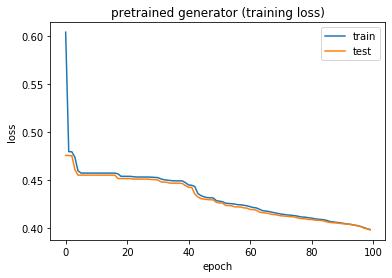

In [8]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.legend(["train", "test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("pretrained generator (training loss)")
plt.savefig("../result/pretrained_generator_loss.png")


In [ ]:
# Pretrain Discriminator
dis_criterion = nn.NLLLoss(reduction='sum')
dis_optimizer = optim.Adam(discriminator.parameters())
if args.cuda:
    dis_criterion = dis_criterion.cuda()
print('Pretrain Discriminator ...')
for epoch in range(5):
    generate_samples(generator, BATCH_SIZE, GENERATED_NUM, NEGATIVE_FILE)
    dis_data_iter = DisDataIter(POSITIVE_FILE, NEGATIVE_FILE, BATCH_SIZE)
    for _ in range(3):
        loss = train_epoch(discriminator, dis_data_iter, dis_criterion, dis_optimizer)
        print('Epoch [%d], loss: %f' % (epoch, loss))
# Adversarial Training
rollout = Rollout(generator, 0.8)
print('#####################################################')
print('Start Adeversatial Training...\n')
gen_gan_loss = GANLoss()
gen_gan_optm = optim.Adam(generator.parameters())
if args.cuda:
    gen_gan_loss = gen_gan_loss.cuda()
gen_criterion = nn.NLLLoss(reduction='sum')
if args.cuda:
    gen_criterion = gen_criterion.cuda()
dis_criterion = nn.NLLLoss(reduction='sum')
dis_optimizer = optim.Adam(discriminator.parameters())
if args.cuda:
    dis_criterion = dis_criterion.cuda()
for total_batch in range(TOTAL_BATCH):
    ## Train the generator for one step
    for it in range(1):
        samples = generator.sample(BATCH_SIZE, MAX_SEQ_LEN)
        # construct the input to the genrator, add zeros before samples and delete the last column
        zeros = torch.zeros((BATCH_SIZE, 1)).type(torch.LongTensor)
        if samples.is_cuda:
            zeros = zeros.cuda()
        inputs = Variable(torch.cat([zeros, samples.data], dim = 1)[:, :-1].contiguous())
        targets = Variable(samples.data).contiguous().view((-1,))
        # calculate the reward
        rewards = rollout.get_reward(samples, 16, discriminator)
        rewards = Variable(torch.Tensor(rewards))
        rewards = torch.exp(rewards).contiguous().view((-1,))
        if args.cuda:
            rewards = rewards.cuda()
        prob = generator.forward(inputs)
        loss = gen_gan_loss(prob, targets, rewards)
        gen_gan_optm.zero_grad()
        loss.backward()
        gen_gan_optm.step()

    if total_batch % 1 == 0 or total_batch == TOTAL_BATCH - 1:
        generate_samples(generator, BATCH_SIZE, GENERATED_NUM, EVAL_FILE)
        eval_iter = GenDataIter(EVAL_FILE, BATCH_SIZE)
        loss = eval_epoch(target_lstm, eval_iter, gen_criterion)
        print('Batch [%d] True Loss: %f' % (total_batch, loss))
    rollout.update_params()

    for _ in range(4):
        generate_samples(generator, BATCH_SIZE, GENERATED_NUM, NEGATIVE_FILE)
        dis_data_iter = DisDataIter(POSITIVE_FILE, NEGATIVE_FILE, BATCH_SIZE)
        for _ in range(2):
            loss = train_epoch(discriminator, dis_data_iter, dis_criterion, dis_optimizer)

In [2]:


def generate_samples(model, batch_size, generated_num, output_file):
    samples = []
    for _ in range(int(generated_num / batch_size)):
        sample = model.sample(batch_size, MAX_SEQ_LEN).cpu().data.numpy().tolist()
        samples.extend(sample)
    with open(output_file, 'w') as fout:
        for sample in samples:
            string = ' '.join([str(s) for s in sample])
            fout.write('%s\n' % string)

def train_epoch(model, data_iter, criterion, optimizer):
    total_loss = 0.
    total_words = 0.
    for (data, target) in data_iter:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        target = target.contiguous().view(-1)
        pred = model.forward(data)
        loss = criterion(pred, target)
        total_loss += loss.item()
        total_words += data.size(0) * data.size(1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    data_iter.reset()
    return math.exp(total_loss / total_words)

def eval_epoch(model, data_iter, criterion):
    total_loss = 0.
    total_words = 0.
    with torch.no_grad():
        for (data, target) in data_iter:#tqdm(
            #data_iter, mininterval=2, desc=' - Training', leave=False):
            data = Variable(data)
            target = Variable(target)
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            target = target.contiguous().view(-1)
            pred = model.forward(data)
            loss = criterion(pred, target)
            total_loss += loss.item()
            total_words += data.size(0) * data.size(1)
        data_iter.reset()

    assert total_words > 0  # Otherwise NullpointerException
    return math.exp(total_loss / total_words)

class GANLoss(nn.Module):
    """Reward-Refined NLLLoss Function for adversial training of Gnerator"""
    def __init__(self):
        super(GANLoss, self).__init__()

    def forward(self, prob, target, reward):
        """
        Args:
            prob: (N, C), torch Variable
            target : (N, ), torch Variable
            reward : (N, ), torch Variable
        """
        N = target.size(0)
        C = prob.size(1)
        one_hot = torch.zeros((N, C))
        if prob.is_cuda:
            one_hot = one_hot.cuda()
        one_hot.scatter_(1, target.data.view((-1,1)), 1)
        one_hot = one_hot.type(torch.ByteTensor)
        one_hot = Variable(one_hot)
        if prob.is_cuda:
            one_hot = one_hot.cuda()
        loss = torch.masked_select(prob, one_hot)
        loss = loss * reward
        loss =  -torch.sum(loss)
        return loss


def main():
    random.seed(SEED)
    np.random.seed(SEED)

    # Define Networks
    generator = Generator(g_args, args.cuda)
    discriminator = Discriminator(d_args)
    if args.cuda:
        generator = generator.cuda()
        discriminator = discriminator.cuda()
    # Generate toy data using target lstm
    print('Generating data ...')
    generate_samples(target_lstm, BATCH_SIZE, GENERATED_NUM, POSITIVE_FILE)

    # Load data from file
    gen_data_iter = GenDataIter(POSITIVE_FILE, BATCH_SIZE)

    # Pretrain Generator using MLE
    gen_criterion = nn.NLLLoss(reduction='sum')
    gen_optimizer = optim.Adam(generator.parameters())
    if args.cuda:
        gen_criterion = gen_criterion.cuda()
    print('Pretrain with MLE ...')
    for epoch in range(PRE_EPOCH_NUM):
        loss = train_epoch(generator, gen_data_iter, gen_criterion, gen_optimizer)
        print('Epoch [%d] Model Loss: %f'% (epoch, loss))
        generate_samples(generator, BATCH_SIZE, GENERATED_NUM, EVAL_FILE)
        eval_iter = GenDataIter(EVAL_FILE, BATCH_SIZE)
        loss = eval_epoch(target_lstm, eval_iter, gen_criterion)
        print('Epoch [%d] True Loss: %f' % (epoch, loss))

    # Pretrain Discriminator
    dis_criterion = nn.NLLLoss(reduction='sum')
    dis_optimizer = optim.Adam(discriminator.parameters())
    if args.cuda:
        dis_criterion = dis_criterion.cuda()
    print('Pretrain Discriminator ...')
    for epoch in range(5):
        generate_samples(generator, BATCH_SIZE, GENERATED_NUM, NEGATIVE_FILE)
        dis_data_iter = DisDataIter(POSITIVE_FILE, NEGATIVE_FILE, BATCH_SIZE)
        for _ in range(3):
            loss = train_epoch(discriminator, dis_data_iter, dis_criterion, dis_optimizer)
            print('Epoch [%d], loss: %f' % (epoch, loss))
    # Adversarial Training
    rollout = Rollout(generator, 0.8)
    print('#####################################################')
    print('Start Adeversatial Training...\n')
    gen_gan_loss = GANLoss()
    gen_gan_optm = optim.Adam(generator.parameters())
    if args.cuda:
        gen_gan_loss = gen_gan_loss.cuda()
    gen_criterion = nn.NLLLoss(reduction='sum')
    if args.cuda:
        gen_criterion = gen_criterion.cuda()
    dis_criterion = nn.NLLLoss(reduction='sum')
    dis_optimizer = optim.Adam(discriminator.parameters())
    if args.cuda:
        dis_criterion = dis_criterion.cuda()
    for total_batch in range(TOTAL_BATCH):
        ## Train the generator for one step
        for it in range(1):
            samples = generator.sample(BATCH_SIZE, MAX_SEQ_LEN)
            # construct the input to the genrator, add zeros before samples and delete the last column
            zeros = torch.zeros((BATCH_SIZE, 1)).type(torch.LongTensor)
            if samples.is_cuda:
                zeros = zeros.cuda()
            inputs = Variable(torch.cat([zeros, samples.data], dim = 1)[:, :-1].contiguous())
            targets = Variable(samples.data).contiguous().view((-1,))
            # calculate the reward
            rewards = rollout.get_reward(samples, 16, discriminator)
            rewards = Variable(torch.Tensor(rewards))
            rewards = torch.exp(rewards).contiguous().view((-1,))
            if args.cuda:
                rewards = rewards.cuda()
            prob = generator.forward(inputs)
            loss = gen_gan_loss(prob, targets, rewards)
            gen_gan_optm.zero_grad()
            loss.backward()
            gen_gan_optm.step()

        if total_batch % 1 == 0 or total_batch == TOTAL_BATCH - 1:
            generate_samples(generator, BATCH_SIZE, GENERATED_NUM, EVAL_FILE)
            eval_iter = GenDataIter(EVAL_FILE, BATCH_SIZE)
            loss = eval_epoch(target_lstm, eval_iter, gen_criterion)
            print('Batch [%d] True Loss: %f' % (total_batch, loss))
        rollout.update_params()

        for _ in range(4):
            generate_samples(generator, BATCH_SIZE, GENERATED_NUM, NEGATIVE_FILE)
            dis_data_iter = DisDataIter(POSITIVE_FILE, NEGATIVE_FILE, BATCH_SIZE)
            for _ in range(2):
                loss = train_epoch(discriminator, dis_data_iter, dis_criterion, dis_optimizer)
if __name__ == '__main__':
    main()